# Premier League:
## Sports exploratory analysis on new signings and 2022/23 season's predictions

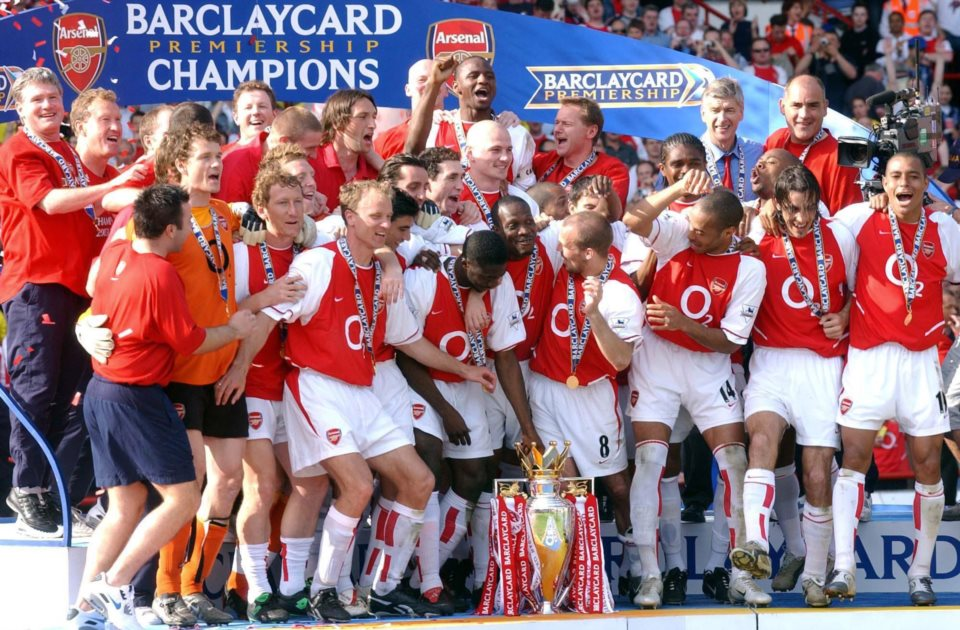

### Project Overview

For this project I have given myself the task of putting my Data Science skills to test by analyzing the most popular and important sport in the world; football. Within the sport, arguably the biggest and most important domestic competition in the world is the English Premier League. Played in the UK, where the top 20 teams in the country face each other, home and away, for glory and bragging rights over their rival fans. 

In this project I will be scraping data online from the previous 5 seasons of the Premier League to try to predict the performance of the teams in this ongoing new season. With this information, I will play the role of a scout and try to look for the talent necessary for underperforming teams. The goal will be to find the right player and predict, given data of an individual, the footballer's potential. This analysis could be used by professional teams and scouts to see the potential of a player, based on current available information, and whether they should be brought into the team.

Importing libraries we will use in this project:

In [86]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from collections import Counter
import html5lib
import warnings
from scipy.stats import poisson,skellam
import pickle
warnings.filterwarnings("ignore")

### Scraping data

Initially we will use the BeautifulSoup library to scrape the web for stats of the five previous seasons of the first division of English football:

In [3]:
# Scraping match data for the past 5 seasons
years = list(range(2022,2016,-1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"

In [4]:
years

[2022, 2021, 2020, 2019, 2018, 2017]

In [5]:
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    #editing team's name and also adding shooting stats
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/shooting/' in l]
        
        data = requests.get(f"https://fbref.com{links[0]}")
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        try:
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
        except ValueError:
            continue
        team_data = team_data[team_data["Comp"] == "Premier League"]
        team_data["Season"] = year
        team_data["Team"] = team_name
        all_matches.append(team_data)

In [6]:
#combing data and cleaning it
matches = pd.concat(all_matches)
matches.columns = [c.lower() for c in matches.columns]
pd.set_option('display.max_columns', None)
matches["date"] = pd.to_datetime(matches["date"])

In [7]:
del matches["comp"]
del matches["notes"]
del matches["match report"]

In [8]:
#Dropping the fixtures from 16/17 and 22/23 seasons
matches.drop(matches[(matches['date'] < "2017-08-01")].index, inplace=True)
matches.drop(matches[(matches['date'] > "2022-05-01")].index, inplace=True)

In [9]:
# Checking for null values
matches.isnull().any().any(), matches.shape

(True, (2335, 24))

In [10]:
rows = matches.shape[0]

# Drop the NULL rows
matches = matches.dropna()

print(matches.isnull().any().any(), matches.shape)

#Checking for duplicates

print(sum(matches.duplicated()))

False (1845, 24)
0


In [11]:
matches.index = range(matches.shape[0])
matches

date   time         round  day venue result gf ga        opponent  \
0    2021-09-25  12:30   Matchweek 6  Sat  Away      W  1  0         Chelsea   
1    2021-10-03  16:30   Matchweek 7  Sun  Away      D  2  2       Liverpool   
2    2021-10-16  15:00   Matchweek 8  Sat  Home      W  2  0         Burnley   
3    2021-10-23  17:30   Matchweek 9  Sat  Away      W  4  1        Brighton   
4    2021-10-30  15:00  Matchweek 10  Sat  Home      L  0  2  Crystal Palace   
...         ...    ...           ...  ...   ...    ... .. ..             ...   
1840 2018-02-12  20:00  Matchweek 27  Mon  Away      L  0  3         Chelsea   
1841 2018-02-24  15:00  Matchweek 28  Sat  Home      L  1  2    Huddersfield   
1842 2018-03-03  15:00  Matchweek 29  Sat  Away      L  0  1         Watford   
1843 2018-03-10  15:00  Matchweek 30  Sat  Home      L  1  4  Leicester City   
1844 2018-03-17  15:00  Matchweek 31  Sat  Away      L  1  2     Bournemouth   

       xg  xga  poss  attendance          captain formation          referee  \
0     1.7  0.3  60.0     40036.0       Rúben Dias     4-3-3   Michael Oliver   
1     1.2  1.0  51.0     53102.0       Rúben Dias     4-3-3     Paul Tierney   
2     1.9  1.0  69.0     52711.0  Kevin De Bruyne     4-3-3  Martin Atkinson   
3     3.9  1.3  52.0     31215.0   İlkay Gündoğan     4-3-3     Kevin Friend   
4     1.1  1.1  68.0     53014.0       Rúben Dias     4-3-3   Andre Marriner   
...   ...  ...   ...         ...              ...       ...              ...   
1840  0.7  2.3  43.0     41071.0      Jonny Evans     3-5-2        Lee Mason   
1841  1.2  1.1  53.0     25920.0      Jonny Evans     4-4-2    Jonathan Moss   
1842  0.7  1.4  47.0     20022.0      Jonny Evans     4-3-3     Paul Tierney   
1843  0.6  1.7  44.0     23558.0       Ben Foster     4-3-3    Robert Madley   
1844  1.2  0.5  39.0     10242.0      Jonny Evans     3-5-2     Graham Scott   

        sh   sot  dist   fk   pk  pkatt  season                  team  
0     15.0   3.0  16.5  0.0  0.0    0.0    2021       Manchester City  
1     12.0   3.0  16.8  1.0  0.0    0.0    2021       Manchester City  
2     16.0   6.0  14.6  0.0  0.0    0.0    2021       Manchester City  
3     23.0  13.0  15.7  1.0  0.0    0.0    2021       Manchester City  
4     14.0   3.0  17.0  0.0  0.0    0.0    2021       Manchester City  
...    ...   ...   ...  ...  ...    ...     ...                   ...  
1840   8.0   1.0  17.6  0.0  0.0    0.0    2017  West Bromwich Albion  
1841  11.0   3.0  15.4  1.0  0.0    0.0    2017  West Bromwich Albion  
1842   8.0   2.0  16.1  1.0  0.0    0.0    2017  West Bromwich Albion  
1843   7.0   2.0  16.8  0.0  0.0    0.0    2017  West Bromwich Albion  
1844  11.0   5.0  15.6  0.0  0.0    0.0    2017  West Bromwich Albion  

[1845 rows x 24 columns]

In [12]:
# Saving to CSV to save up some time
matches.to_csv("matches.csv")

### Some stats to take into account for the 5 previous seasons:

Now that we have the data set we can explore it and better understand what happend in this past 5 seasons:

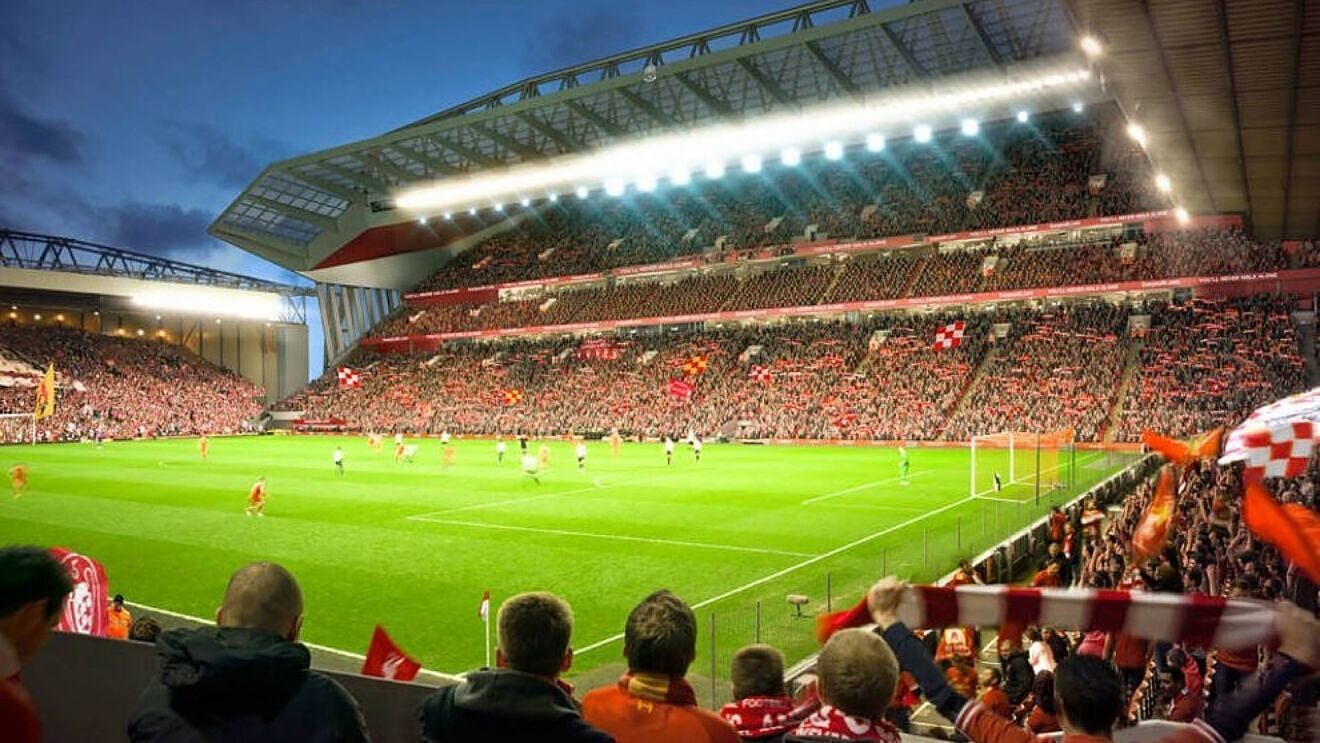

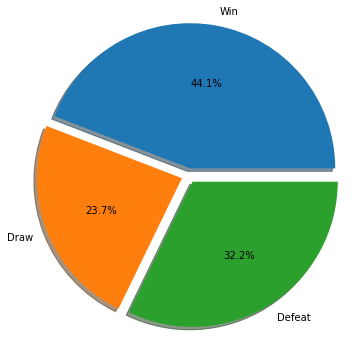

In [13]:
# Chances of result at Home

result = 'Win', 'Draw', 'Defeat'
home = matches.copy()
home = home[home['venue'] == "Home"]
home['Win'] = home['result'].apply(lambda x: 1 if x == "W" else 0)
home['Draw'] = home['result'].apply(lambda x: 1 if x == "D" else 0)
home['Lose'] = home['result'].apply(lambda x: 1 if x == "L" else 0)
Win = home['Win'].sum()
Draw = home['Draw'].sum()
Lose = home['Lose'].sum()
pie = [Win, Draw, Lose]

plt.pie(pie, labels = result ,shadow = True, explode = (0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()

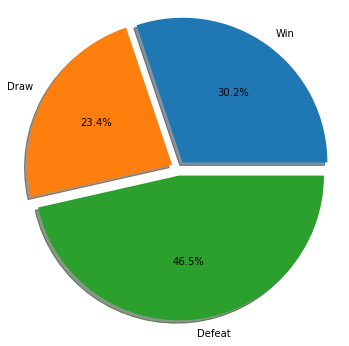

In [14]:
# Chances of result at Away

result = 'Win', 'Draw', 'Defeat'
away = matches.copy()
away = away[away['venue'] == "Away"]
away['Win'] = away['result'].apply(lambda x: 1 if x == "W" else 0)
away['Draw'] = away['result'].apply(lambda x: 1 if x == "D" else 0)
away['Lose'] = away['result'].apply(lambda x: 1 if x == "L" else 0)
Win = away['Win'].sum()
Draw = away['Draw'].sum()
Lose = away['Lose'].sum()
pie2 = [Win, Draw, Lose]

plt.pie(pie2, labels = result,shadow = True, explode = (0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()

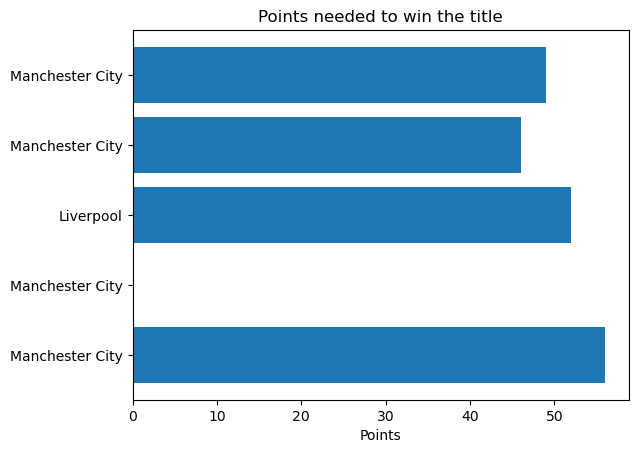

In [95]:
# Points needed to be crowned champion in the past 5 seasons

points = matches.copy()
points['season'] = points['season'].apply(str)

manchestercity2017 = points[points['team'] == "Manchester City"]
manchestercity2017 = manchestercity2017[manchestercity2017['season'] == "2017"]
manchestercity2017['Win'] = manchestercity2017['result'].apply(lambda x: 3 if x == "W" else 0)
manchestercity2017['Draw'] = manchestercity2017['result'].apply(lambda x: 1 if x == "D" else 0)
Win2017 = manchestercity2017['Win'].sum()
Draw2017 = manchestercity2017['Draw'].sum()
Total2017 = Win2017 + Draw2017

manchestercity2018 = points[points['team'] == "Manchester City"]
manchestercity2018 = manchestercity2018[manchestercity2018['season'] == "2018"]
manchestercity2018['Win'] = manchestercity2018['result'].apply(lambda x: 3 if x == "W" else 0)
manchestercity2018['Draw'] = manchestercity2018['result'].apply(lambda x: 1 if x == "D" else 0)
Win2018 = manchestercity2018['Win'].sum()
Draw2018 = manchestercity2018['Draw'].sum()
Total2018 = Win2018 + Draw2018

liverpool2019 = points[points['team'] == "Liverpool"]
liverpool2019 = liverpool2019[liverpool2019['season'] == "2019"]
liverpool2019['Win'] = liverpool2019['result'].apply(lambda x: 3 if x == "W" else 0)
liverpool2019['Draw'] = liverpool2019['result'].apply(lambda x: 1 if x == "D" else 0)
Win2019 = liverpool2019['Win'].sum()
Draw2019 = liverpool2019['Draw'].sum()
Total2019 = Win2019 + Draw2019

manchestercity2020 = points[points['team'] == "Manchester City"]
manchestercity2020 = manchestercity2020[manchestercity2020['season'] == "2020"]
manchestercity2020['Win'] = manchestercity2020['result'].apply(lambda x: 3 if x == "W" else 0)
manchestercity2020['Draw'] = manchestercity2020['result'].apply(lambda x: 1 if x == "D" else 0)
Win2020 = manchestercity2020['Win'].sum()
Draw2020 = manchestercity2020['Draw'].sum()
Total2020 = Win2020 + Draw2020

manchestercity2021 = points[points['team'] == "Manchester City"]
manchestercity2021 = manchestercity2021[manchestercity2021['season'] == "2021"]
manchestercity2021['Win'] = manchestercity2021['result'].apply(lambda x: 3 if x == "W" else 0)
manchestercity2021['Draw'] = manchestercity2021['result'].apply(lambda x: 1 if x == "D" else 0)
Win2021 = manchestercity2021['Win'].sum()
Draw2021 = manchestercity2021['Draw'].sum()
Total2021 = Win2021 + Draw2021

plt.rcdefaults()
fig, ax = plt.subplots()

winner = ("Manchester City","Manchester City","Liverpool","Manchester City","Manchester City")
y_pos = np.arange(len(winner))
Points = (Total2017, Total2018, Total2019, Total2020, Total2021)

ax.barh(y_pos, Points, align='center')
ax.set_yticks(y_pos, labels=winner)
ax.invert_yaxis()
ax.set_xlabel('Points')
ax.set_title('Points needed to win the title')

plt.show()

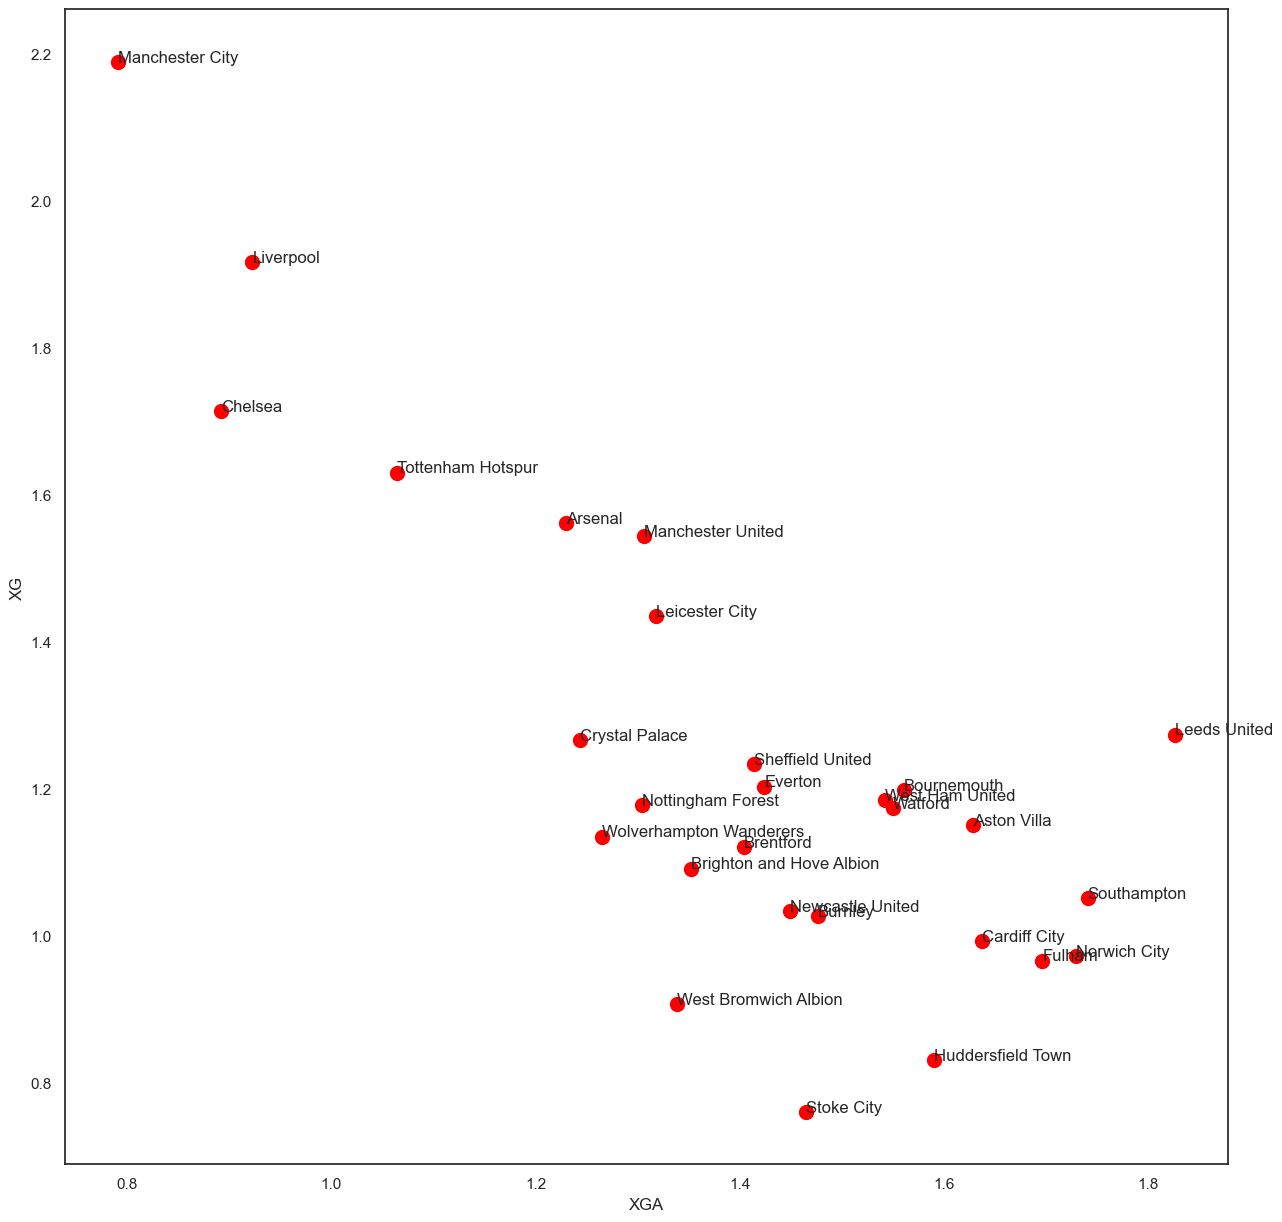

In [93]:
#Expected goals against expected goals against

goals = matches.copy()
xg = goals.groupby("team")["xg"].mean()
xga = goals.groupby("team")["xga"].mean()

teams = ["Arsenal","Aston Villa","Bournemouth","Brentford","Brighton and Hove Albion","Burnley","Cardiff City","Chelsea",
"Crystal Palace","Everton","Fulham","Huddersfield Town","Leeds United","Leicester City","Liverpool","Manchester City",
"Manchester United", "Newcastle United","Norwich City","Nottingham Forest","Sheffield United","Southampton",
"Stoke City","Tottenham Hotspur", "Watford", "West Bromwich Albion", "West Ham United",
"Wolverhampton Wanderers"]

plt.figure(figsize=(15,15))
plt.scatter(x=xga, y=xg, s=100,color="red")
plt.xlabel("XGA")
plt.ylabel("XG")
for i, label in enumerate(teams):
    plt.annotate(label, (xga[i], xg[i]))

plt.show()

# Predicting Results of Season 22/223

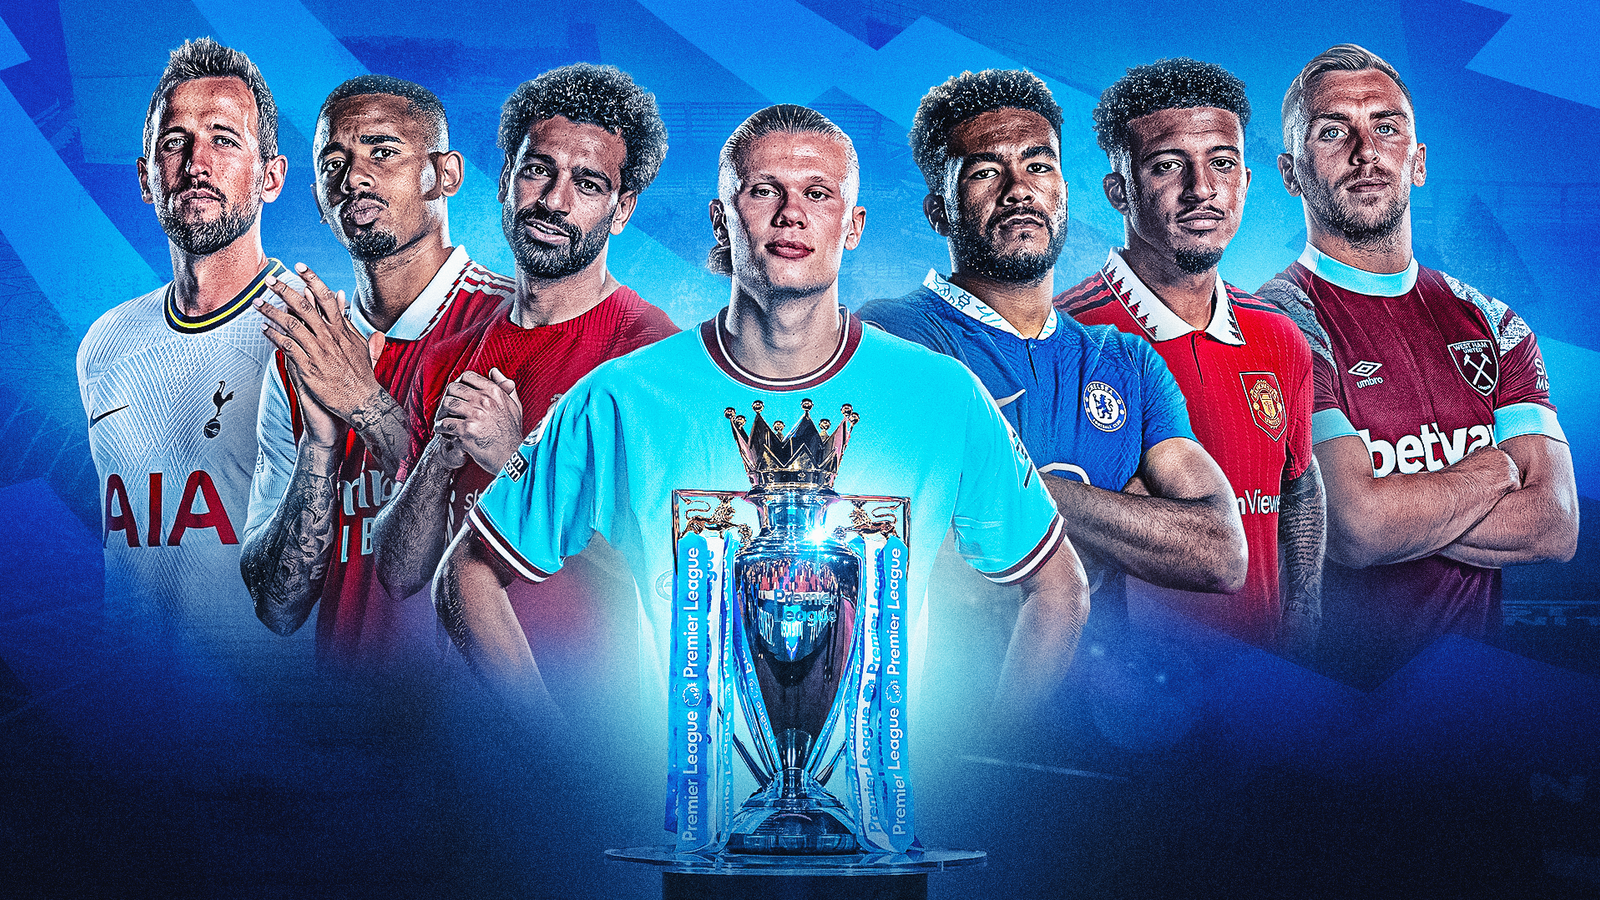

In [17]:
# import required libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score, confusion_matrix, roc_auc_score, classification_report, log_loss

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import scale, StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

Preparing the dataframe for the creation of a model

In [18]:
#Determing where the game is played so we can take into account home advantage
matches["venue_code"] = matches["venue"].astype("category").cat.codes

#assigning numerical value to each opponent and referee
matches["team_code"] = matches["team"].astype("category").cat.codes
matches["opp_code"] = matches["opponent"].astype("category").cat.codes
matches["ref_code"] = matches["referee"].astype("category").cat.codes

#Taking into account time game was played
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
matches["day_code"] = matches["date"].dt.dayofweek

# We need to know if the team won or not so we can predict results of 22/23 season
matches["target"] = (matches["result"] == "W").astype('int')

# Grouping by team
grouped_matches = matches.groupby("team")

group = grouped_matches.get_group("Arsenal").sort_values("date")

# Creating rolling stats to calculate form of 3 previous matches
def team_form(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]

team_form(group, cols, new_cols)

matches_wForm = matches.groupby("team").apply(lambda x: team_form(x, cols, new_cols))
matches_wForm = matches_wForm.droplevel('team')
matches_wForm.index = range(matches_wForm.shape[0])
matches_wForm

date   time         round  day venue result gf ga         opponent  \
0    2017-10-22  13:30   Matchweek 9  Sun  Away      W  5  2          Everton   
1    2017-10-28  15:00  Matchweek 10  Sat  Home      W  2  1     Swansea City   
2    2017-11-05  14:15  Matchweek 11  Sun  Away      L  1  3  Manchester City   
3    2017-11-18  12:30  Matchweek 12  Sat  Home      W  2  0        Tottenham   
4    2017-11-26  14:00  Matchweek 13  Sun  Away      W  1  0          Burnley   
...         ...    ...           ...  ...   ...    ... .. ..              ...   
1756 2022-03-10  19:30  Matchweek 19  Thu  Home      W  4  0          Watford   
1757 2022-03-13  14:00  Matchweek 29  Sun  Away      W  1  0          Everton   
1758 2022-03-18  20:00  Matchweek 30  Fri  Home      L  2  3     Leeds United   
1759 2022-04-02  15:00  Matchweek 31  Sat  Home      W  2  1      Aston Villa   
1760 2022-04-08  20:00  Matchweek 32  Fri  Away      L  0  1    Newcastle Utd   

       xg  xga  poss  attendance            captain formation         referee  \
0     2.8  1.3  67.0     39189.0    Per Mertesacker     3-4-3    Craig Pawson   
1     1.6  0.6  72.0     59493.0    Per Mertesacker     3-4-3       Lee Mason   
2     0.4  2.0  42.0     54286.0  Laurent Koscielny     3-4-3  Michael Oliver   
3     1.4  1.4  42.0     59530.0  Laurent Koscielny     3-4-3       Mike Dean   
4     1.8  0.4  63.0     21722.0  Laurent Koscielny     3-4-3       Lee Mason   
...   ...  ...   ...         ...                ...       ...             ...   
1756  0.9  0.9  65.0     29658.0        Conor Coady     3-4-3  Darren England   
1757  0.8  0.5  60.0     39112.0        Conor Coady     3-5-2  Michael Oliver   
1758  0.8  2.2  47.0     31842.0        Conor Coady     3-4-3    Kevin Friend   
1759  1.2  2.1  49.0     31012.0        Conor Coady     3-4-3  Darren England   
1760  0.3  1.6  58.0     52164.0        Conor Coady     3-4-3    Peter Bankes   

        sh   sot  dist   fk   pk  pkatt  season                     team  \
0     28.0  14.0  16.9  2.0  0.0    0.0    2017                  Arsenal   
1     17.0   5.0  16.2  0.0  0.0    0.0    2017                  Arsenal   
2      6.0   3.0  21.1  1.0  0.0    0.0    2017                  Arsenal   
3     14.0   5.0  16.4  1.0  0.0    0.0    2017                  Arsenal   
4     17.0   1.0  21.5  0.0  1.0    1.0    2017                  Arsenal   
...    ...   ...   ...  ...  ...    ...     ...                      ...   
1756  11.0   5.0  18.2  0.0  0.0    0.0    2021  Wolverhampton Wanderers   
1757  14.0   3.0  20.7  0.0  0.0    0.0    2021  Wolverhampton Wanderers   
1758  14.0   8.0  20.6  0.0  0.0    0.0    2021  Wolverhampton Wanderers   
1759  11.0   4.0  14.3  0.0  0.0    0.0    2021  Wolverhampton Wanderers   
1760   5.0   2.0  18.0  0.0  0.0    0.0    2021  Wolverhampton Wanderers   

      venue_code  team_code  opp_code  ref_code  hour  day_code  target  \
0              0          0         9         4    13         6       1   
1              1          0        22        12    15         5       1   
2              0          0        15        15    14         6       0   
3              1          0        23        17    12         5       1   
4              0          0         5        12    14         6       1   
...          ...        ...       ...       ...   ...       ...     ...   
1756           1         27        24         5    19         3       1   
1757           0         27         9        15    14         6       1   
1758           1         27        12        11    20         4       0   
1759           1         27         1         5    15         5       1   
1760           0         27        17        21    20         4       0   

      gf_rolling  ga_rolling  sh_rolling  sot_rolling  dist_rolling  \
0       1.666667    0.666667   16.666667     6.333333     18.933333   
1       2.666667    1.333333   21.000000     9.333333     18.333333   
2       2.666667    1.666667   18.0000

In order to predict the performance of the teams I asked the question what factor will I take into account, in this project I will focus on predict the result of home matches. I want to know if the home team will win, tie or lost the match. As this will not be quantified, I will be neededing a classification model. As I woul dbe doing a Logistic Classification to see if the team either won or lost/tie.

In [19]:
test_predictors = matches_wForm[["xg", "xga","poss","ref_code","venue_code", "opp_code", "hour", "day_code",
                           "sh","sot","dist","fk","pk","pkatt","gf_rolling","ga_rolling","sh_rolling","sot_rolling",
                          "dist_rolling", "fk_rolling","pk_rolling","pkatt_rolling"]]

target = matches_wForm[["target"]]

In [20]:
X_train,X_test,y_train,y_test = train_test_split(test_predictors, target, test_size=0.2, stratify = target)

names = ["Logistic Regression","Decision Tree", "Random Forest", "Neural Net"]

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000)]

for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        
        print(name, accuracy)

Logistic Regression 0.8130311614730878
Decision Tree 0.7308781869688386
Random Forest 0.6770538243626062
Neural Net 0.7677053824362606


### Random Forest

In [96]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

predictors = ["xg", "xga","poss","ref_code","venue_code", "opp_code", "hour", "day_code",
                           "sh","sot","dist","fk","pk","pkatt","gf_rolling","ga_rolling","sh_rolling","sot_rolling",
                          "dist_rolling", "fk_rolling","pk_rolling","pkatt_rolling"]

In [97]:
def make_predictions(data, predictors):
    train = data[data["date"] < '2022-01-01']
    test = data[data["date"] > '2022-01-01']
    rf.fit(train[predictors], train["target"])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)
    score = precision_score(test["target"], preds)
    return combined, error

In [98]:
combined, score = make_predictions(matches_wForm, predictors)

In [99]:
score

0.7096774193548387

In [100]:
combined = combined.merge(matches_wForm[["date", "team", "opponent", "result"]], left_index=True, right_index=True)

In [101]:
combined

actual  predicted       date                     team       opponent  \
72         0          0 2022-01-23                  Arsenal        Burnley   
73         1          1 2022-02-10                  Arsenal         Wolves   
74         1          1 2022-02-19                  Arsenal      Brentford   
75         1          1 2022-02-24                  Arsenal         Wolves   
76         1          0 2022-03-06                  Arsenal        Watford   
...      ...        ...        ...                      ...            ...   
1756       1          0 2022-03-10  Wolverhampton Wanderers        Watford   
1757       1          0 2022-03-13  Wolverhampton Wanderers        Everton   
1758       0          0 2022-03-18  Wolverhampton Wanderers   Leeds United   
1759       1          0 2022-04-02  Wolverhampton Wanderers    Aston Villa   
1760       0          0 2022-04-08  Wolverhampton Wanderers  Newcastle Utd   

     result  
72        D  
73        W  
74        W  
75        W  
76        W  
...     ...  
1756      W  
1757      W  
1758      L  
1759      W  
1760      L  

[211 rows x 6 columns]

In [89]:
#deployment
file_name = 'premierleague_model'

with open(file_name, 'wb') as file:
    pickle.dump(rf,file)

In [ ]:
from flask import Flask, render_template, request, redirect, url_for
import pickle

app = Flask(__name__)


@app.route('/')
def temp():
    return render_template('template.html')

@app.route('/',methods=['POST','GET'])
def get_input():
    if request.method == 'POST':
        info = request.form['search']
        return redirect(url_for('run_pred',values=info))

@app.route('/run_pred/<values>')
def run_pred(values):
    import numpy as np 
    
    values = values.split(',')
    values = np.array(values)
    values = values.reshape(1,-1)
    
    with open('premierleague_model', 'wb') as file:
        pickle_model = pickle.load(file)
        
    model = pickle_model
    pred = model.predict(values)
    
    if pred == 0:
        return 'Our model predicts that the home team WINS!'
    return 'Our model predicts that the home team LOST or DRAW!'
    
if __name__ == '__main__':
    app.run(host='127.0.0.1', port=5000, debug=True, threaded=True)

### Logistic Regression

In [116]:
lr = LogisticRegression()

predictors = ["xg", "xga","poss","ref_code","venue_code", "opp_code", "hour", "day_code",
                           "sh","sot","dist","fk","pk","pkatt","gf_rolling","ga_rolling","sh_rolling","sot_rolling",
                          "dist_rolling", "fk_rolling","pk_rolling","pkatt_rolling"]

In [117]:
def make_predictionsLR(data, predictors):
    train = data[data["date"] < '2022-01-01']
    test = data[data["date"] > '2022-01-01']
    lr.fit(train[predictors], train["target"])
    preds = lr.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)
    score = precision_score(test["target"], preds)
    return combined, score

In [118]:
combined, score = make_predictionsLR(matches_wForm, predictors)

In [119]:
score

0.7096774193548387

In [120]:
combined = combined.merge(matches_wForm[["date", "team", "opponent", "result"]], left_index=True, right_index=True)

In [121]:
combined

actual  predicted       date                     team       opponent  \
72         0          0 2022-01-23                  Arsenal        Burnley   
73         1          0 2022-02-10                  Arsenal         Wolves   
74         1          1 2022-02-19                  Arsenal      Brentford   
75         1          0 2022-02-24                  Arsenal         Wolves   
76         1          0 2022-03-06                  Arsenal        Watford   
...      ...        ...        ...                      ...            ...   
1756       1          0 2022-03-10  Wolverhampton Wanderers        Watford   
1757       1          0 2022-03-13  Wolverhampton Wanderers        Everton   
1758       0          0 2022-03-18  Wolverhampton Wanderers   Leeds United   
1759       1          0 2022-04-02  Wolverhampton Wanderers    Aston Villa   
1760       0          0 2022-04-08  Wolverhampton Wanderers  Newcastle Utd   

     result  
72        D  
73        W  
74        W  
75        W  
76        W  
...     ...  
1756      W  
1757      W  
1758      L  
1759      W  
1760      L  

[211 rows x 6 columns]

In [126]:
train = matches_wForm[matches_wForm["date"] < '2022-01-01']
test = matches_wForm[matches_wForm["date"] > '2022-01-01']
confusion_matrix(test[predictors], test["target"])

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

# Attacking Player Scouting
## exploratory data analysis

In [37]:
shooting_url = "https://fbref.com/en/comps/Big5/2021-2022/shooting/players/2021-2022-Big-5-European-Leagues-Stats"

data = requests.get(shooting_url)
soup = BeautifulSoup(data.text)
shooting_table = soup.select('table.stats_table')[0]
shooting = pd.read_html(data.text)[0]
shooting.columns = shooting.columns.droplevel()
time.sleep(1)

In [38]:
del shooting["Rk"]
del shooting["Matches"]

In [39]:
shooting

Player   Nation Pos          Squad                Comp Age  \
0            Max Aarons  eng ENG  DF   Norwich City  eng Premier League  21   
1      Yunis Abdelhamid   ma MAR  DF          Reims          fr Ligue 1  33   
2     Salis Abdul Samed   gh GHA  MF  Clermont Foot          fr Ligue 1  21   
3       Laurent Abergel   fr FRA  MF        Lorient          fr Ligue 1  28   
4           Charles Abi   fr FRA  FW  Saint-Étienne          fr Ligue 1  21   
...                 ...      ...  ..            ...                 ...  ..   
3032         Kurt Zouma   fr FRA  DF       West Ham  eng Premier League  26   
3033        Petar Zovko   ba BIH  GK         Spezia          it Serie A  19   
3034      Igor Zubeldia   es ESP  DF  Real Sociedad          es La Liga  24   
3035   Martín Zubimendi   es ESP  MF  Real Sociedad          es La Liga  22   
3036   Szymon Żurkowski   pl POL  MF         Empoli          it Serie A  23   

      Born   90s Gls  Sh SoT  SoT% Sh/90 SoT/90  G/Sh G/SoT  Dist FK PK PKatt  \
0     2000  32.0   0  13   2  15.4  0.41   0.06  0.00  0.00  20.5  0  0     0   
1     1987  33.1   2  18   6  33.3  0.54   0.18  0.11  0.33  18.7  0  0     0   
2     2000  27.4   1  18   5  27.8  0.66   0.18  0.06  0.20  20.3  0  0     0   
3     1993  32.8   0  30   7  23.3  0.91   0.21  0.00  0.00  22.6  0  0     0   
4     2000   0.5   0   0   0   NaN  0.00   0.00   NaN   NaN   NaN  0  0     0   
...    ...   ...  ..  ..  ..   ...   ...    ...   ...   ...   ... .. ..   ...   
3032  1994  23.1   1   7   2  28.6  0.30   0.09  0.14  0.50   6.2  0  0     0   
3033  2002   0.3   0   0   0   NaN  0.00   0.00   NaN   NaN   NaN  0  0     0   
3034  1997  18.3   0   9   2  22.2  0.49   0.11  0.00  0.00  17.8  0  0     0   
3035  1999  28.8   2  21  10  47.6  0.73   0.35  0.10  0.20  13.7  0  0     0   
3036  1997  25.6   6  47  17  36.2  1.83   0.66  0.13  0.35  18.8  0  0     0   

       xG npxG npxG/Sh  G-xG np:G-xG  
0     0.7  0.7    0.05  -0.7    -0.7  
1     1.2  1.2    0.07  +0.8    +0.8  
2     0.8  0.8    0.04  +0.2    +0.2  
3     2.0  2.0    0.07  -2.0    -2.0  
4     0.0  0.0     NaN   0.0     0.0  
...   ...  ...     ...   ...     ...  
3032  0.9  0.9    0.12  +0.1    +0.1  
3033  0.0  0.0     NaN   0.0     0.0  
3034  0.8  0.8    0.09  -0.8    -0.8  
3035  2.0  2.0    0.09   0.0     0.0  
3036  4.1  4.1    0.09  +1.9    +1.9  

[3037 rows x 25 columns]

In [40]:
shooting["Player"] = shooting["Player"].astype('str') 
shooting["Nation"] = shooting["Nation"].astype('str') 
shooting["Pos"] = shooting["Pos"].astype('str') 
shooting["Squad"] = shooting["Squad"].astype('str') 
shooting["Comp"] = shooting["Comp"].astype('str') 
shooting["Age"] = shooting["Age"].apply(pd.to_numeric, errors='coerce')
shooting["Born"] = shooting["Born"].apply(pd.to_numeric, errors='coerce')
shooting["90s"] = shooting["90s"].apply(pd.to_numeric, errors='coerce')
shooting["Gls"] = shooting["Gls"].apply(pd.to_numeric, errors='coerce')
shooting["Sh"] = shooting["Sh"].apply(pd.to_numeric, errors='coerce')
shooting["SoT"] = shooting["SoT"].apply(pd.to_numeric, errors='coerce')
shooting["SoT%"] = shooting["SoT%"].apply(pd.to_numeric, errors='coerce')
shooting["Sh/90"] = shooting["Sh/90"].apply(pd.to_numeric, errors='coerce')
shooting["SoT/90"] = shooting["SoT/90"].apply(pd.to_numeric, errors='coerce')
shooting["G/Sh"] = shooting["G/Sh"].apply(pd.to_numeric, errors='coerce')
shooting["G/SoT"] = shooting["G/SoT"].apply(pd.to_numeric, errors='coerce')
shooting["Dist"] = shooting["Dist"].apply(pd.to_numeric, errors='coerce')
shooting["FK"] = shooting["FK"].apply(pd.to_numeric, errors='coerce')
shooting["PK"] = shooting["PK"].apply(pd.to_numeric, errors='coerce')
shooting["PKatt"] = shooting["PKatt"].apply(pd.to_numeric, errors='coerce')
shooting["xG"] = shooting["xG"].apply(pd.to_numeric, errors='coerce')
shooting["npxG"] = shooting["npxG"].apply(pd.to_numeric, errors='coerce')
shooting["npxG/Sh"] = shooting["npxG/Sh"].apply(pd.to_numeric, errors='coerce')
shooting["G-xG"] = shooting["G-xG"].apply(pd.to_numeric, errors='coerce')

shooting.dtypes

Player      object
Nation      object
Pos         object
Squad       object
Comp        object
Age        float64
Born       float64
90s        float64
Gls        float64
Sh         float64
SoT        float64
SoT%       float64
Sh/90      float64
SoT/90     float64
G/Sh       float64
G/SoT      float64
Dist       float64
FK         float64
PK         float64
PKatt      float64
xG         float64
npxG       float64
npxG/Sh    float64
G-xG       float64
np:G-xG     object
dtype: object

In [41]:
#Goals and shot creation
gca_url = "https://fbref.com/en/comps/Big5/2021-2022/gca/players/2021-2022-Big-5-European-Leagues-Stats"

data = requests.get(gca_url)
soup = BeautifulSoup(data.text)
gca_table = soup.select('table.stats_table')[0]
gca = pd.read_html(data.text)[0]
gca.columns = gca.columns.droplevel()
time.sleep(1)

In [42]:
del gca["Rk"]
del gca["Matches"]

In [43]:
gca["Player"] = gca["Player"].astype('str') 
gca["Nation"] = gca["Nation"].astype('str') 
gca["Pos"] = gca["Pos"].astype('str') 
gca["Squad"] = gca["Squad"].astype('str') 
gca["Comp"] = gca["Comp"].astype('str') 
gca["Age"] = gca["Age"].apply(pd.to_numeric, errors='coerce')
gca["Born"] = gca["Born"].apply(pd.to_numeric, errors='coerce')
gca["90s"] = gca["90s"].apply(pd.to_numeric, errors='coerce')
gca["SCA"] = gca["SCA"].apply(pd.to_numeric, errors='coerce')
gca["SCA90"] = gca["SCA90"].apply(pd.to_numeric, errors='coerce')

gca.dtypes

Player       object
Nation       object
Pos          object
Squad        object
Comp         object
Age         float64
Born        float64
90s         float64
SCA         float64
SCA90       float64
PassLive     object
PassDead     object
Drib         object
Sh           object
Fld          object
Def          object
GCA          object
GCA90        object
PassLive     object
PassDead     object
Drib         object
Sh           object
Fld          object
Def          object
dtype: object

In [44]:
gca = gca.drop(gca.iloc[:, 18:24],axis = 1)
gca

Player   Nation Pos          Squad                Comp   Age  \
0            Max Aarons  eng ENG  DF   Norwich City  eng Premier League  21.0   
1      Yunis Abdelhamid   ma MAR  DF          Reims          fr Ligue 1  33.0   
2     Salis Abdul Samed   gh GHA  MF  Clermont Foot          fr Ligue 1  21.0   
3       Laurent Abergel   fr FRA  MF        Lorient          fr Ligue 1  28.0   
4           Charles Abi   fr FRA  FW  Saint-Étienne          fr Ligue 1  21.0   
...                 ...      ...  ..            ...                 ...   ...   
3032         Kurt Zouma   fr FRA  DF       West Ham  eng Premier League  26.0   
3033        Petar Zovko   ba BIH  GK         Spezia          it Serie A  19.0   
3034      Igor Zubeldia   es ESP  DF  Real Sociedad          es La Liga  24.0   
3035   Martín Zubimendi   es ESP  MF  Real Sociedad          es La Liga  22.0   
3036   Szymon Żurkowski   pl POL  MF         Empoli          it Serie A  23.0   

        Born   90s   SCA  SCA90 GCA GCA90  
0     2000.0  32.0  38.0   1.19   5  0.16  
1     1987.0  33.1  21.0   0.63   1  0.03  
2     2000.0  27.4  40.0   1.46   1  0.04  
3     1993.0  32.8  66.0   2.01   5  0.15  
4     2000.0   0.5   0.0   0.00   0  0.00  
...      ...   ...   ...    ...  ..   ...  
3032  1994.0  23.1   6.0   0.26   0  0.00  
3033  2002.0   0.3   0.0   0.00   0  0.00  
3034  1997.0  18.3   8.0   0.44   0  0.00  
3035  1999.0  28.8  34.0   1.18   1  0.03  
3036  1997.0  25.6  60.0   2.34   4  0.16  

[3037 rows x 12 columns]

In [45]:
attacking = pd.merge(
    shooting,
    gca,
    how="inner",
    on=['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s'],
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [46]:
#Checking and deleting null data
print(attacking.isnull().any().any(), attacking.shape)
rows = attacking.shape[0]

# Drop the NULL rows
attacking = attacking.fillna(attacking.mean())

print(attacking.isnull().any().any(), attacking.shape)

#Checking for duplicates and dropping them
attacking = attacking.drop_duplicates()
print(sum(attacking.duplicated()))

True (16377, 29)
False (16377, 29)
0


In [47]:
attacking

Player   Nation Pos            Squad                Comp  \
0        Aaron Connolly   ie IRL  FW         Brighton  eng Premier League   
1       Aaron Cresswell  eng ENG  DF         West Ham  eng Premier League   
2          Aaron Hickey  sct SCO  DF          Bologna          it Serie A   
3          Aaron Lennon  eng ENG  MF          Burnley  eng Premier League   
4        Aaron Ramsdale  eng ENG  GK          Arsenal  eng Premier League   
...                 ...      ...  ..              ...                 ...   
16372    İlkay Gündoğan   de GER  MF  Manchester City  eng Premier League   
16373  Łukasz Fabiański   pl POL  GK         West Ham  eng Premier League   
16374  Łukasz Skorupski   pl POL  GK          Bologna          it Serie A   
16375     Šime Vrsaljko   hr CRO  DF  Atlético Madrid          es La Liga   
16376       Ștefan Radu   ro ROU  DF            Lazio          it Serie A   

        Age    Born   90s  Gls    Sh   SoT       SoT%  Sh/90  SoT/90  \
0      21.0  2000.0   1.7  0.0   2.0   0.0   0.000000   1.15    0.00   
1      31.0  1989.0  30.3  2.0  18.0   3.0  16.700000   0.59    0.10   
2      19.0  2002.0  31.3  5.0  21.0  13.0  61.900000   0.67    0.41   
3      34.0  1987.0  17.2  2.0  12.0   4.0  33.300000   0.70    0.23   
4      23.0  1998.0  34.0  0.0   0.0   0.0  29.183037   0.00    0.00   
...     ...     ...   ...  ...   ...   ...        ...    ...     ...   
16372  30.0  1990.0  20.6  8.0  55.0  18.0  32.700000   2.67    0.87   
16373  36.0  1985.0  37.0  0.0   0.0   0.0  29.183037   0.00    0.00   
16374  30.0  1991.0  36.0  0.0   0.0   0.0  29.183037   0.00    0.00   
16375  29.0  1992.0  10.2  1.0   4.0   1.0  25.000000   0.39    0.10   
16376  34.0  1986.0   6.2  0.0   2.0   1.0  50.000000   0.32    0.16   

           G/Sh     G/SoT       Dist   FK   PK  PKatt   xG  npxG   npxG/Sh  \
0      0.000000  0.276972  14.900000  0.0  0.0    0.0  0.5   0.5  0.230000   
1      0.110000  0.670000  19.900000  8.0  0.0    0.0  1.1   1.1  0.060000   
2      0.240000  0.380000  21.000000  0.0  0.0    0.0  1.1   1.1  0.050000   
3      0.170000  0.500000  19.300000  0.0  0.0    0.0  1.1   1.1  0.090000   
4      0.080245  0.276972  16.963198  0.0  0.0    0.0  0.0   0.0  0.091493   
...         ...       ...        ...  ...  ...    ...  ...   ...       ...   
16372  0.150000  0.440000  13.900000  2.0  0.0    0.0  8.6   8.6  0.160000   
16373  0.080245  0.276972  16.963198  0.0  0.0    0.0  0.0   0.0  0.091493   
16374  0.080245  0.276972  16.963198  0.0  0.0    0.0  0.0   0.0  0.091493   
16375  0.250000  1.000000  13.900000  0.0  0.0    0.0  0.8   0.8  0.210000   
16376  0.000000  0.000000  23.900000  0.0  0.0    0.0  0.1   0.1  0.030000   

       G-xG np:G-xG   SCA  SCA90 GCA GCA90  
0      -0.5    -0.5   2.0   1.15   0  0.00  
1       0.9    +0.9  49.0   1.62   5  0.17  
2       3.9    +3.9  39.0   1.24   4  0.13  
3       0.9    +0.9  32.0   1.86   5  0.29  
4       0.0     0.0   1.0   0.03   1  0.03  
...     ...     ...   ...    ...  ..   ...  
16372  -0.6    -0.6  72.0   3.49   7  0.34  
16373   0.0     0.0   3.0   0.08   0  0.00  
16374   0.0     0.0   1.0   0.03   0  0.00  
16375   0.2    +0.2   9.0   0.89   3  0.30  
16376  -0.1    -0.1   2.0   0.32   0  0.00  

[2922 rows x 29 columns]

For the signing of an attacker for XXX we will focus on a wide player that can play across multiple position
that can aid a team that is in multiple competitions and can help the team rotation, a goalscorer that has good finishing, between the age of 21-26 that comes in a reasonable price.

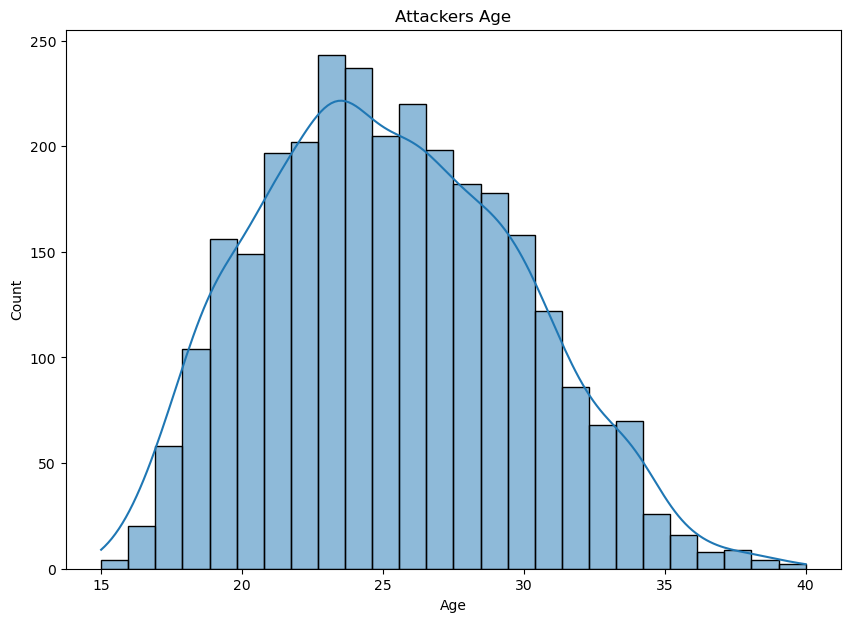

In [48]:
plt.figure(figsize = (10, 7))
sns.histplot(attacking['Age'], kde = True)
plt.title('Attackers Age')
plt.show()

In [49]:
AshortlistN = pd.DataFrame
AshortlistN = attacking.loc[(attacking.Age > 21) & (attacking.Age < 26)]
Ashortlist1 = AshortlistN[AshortlistN.Pos == "FW,MF"]
Ashortlist2 = AshortlistN[AshortlistN.Pos == "MF,MF"]
Ashortlist3 = AshortlistN[AshortlistN.Pos == "FW"]
pdList = [Ashortlist1,Ashortlist2,Ashortlist3]
Ashortlist = pd.concat(pdList)
Ashortlist

Player  Nation    Pos           Squad                Comp  \
37        Ademola Lookman  ng NGA  FW,MF  Leicester City  eng Premier League   
44           Adrian Grbić  at AUT  FW,MF         Lorient          fr Ligue 1   
65     Albert Guðmundsson  is ISL  FW,MF           Genoa          it Serie A   
67           Alberth Elis  hn HON  FW,MF        Bordeaux          fr Ligue 1   
83      Aleksandr Golovin  ru RUS  FW,MF          Monaco          fr Ligue 1   
...                   ...     ...    ...             ...                 ...   
16088         Terem Moffi  ng NGA     FW         Lorient          fr Ligue 1   
16136       Tino Kadewere  zw ZIM     FW            Lyon          fr Ligue 1   
16210      Victor Osimhen  ng NGA     FW          Napoli          it Serie A   
16247       Wesley Moraes  br BRA     FW     Aston Villa  eng Premier League   
16309   Youssef En-Nesyri  ma MAR     FW         Sevilla          es La Liga   

        Age    Born   90s   Gls    Sh   SoT       SoT%  Sh/90  SoT/90  \
37     23.0  1997.0  16.1   6.0  27.0  12.0  44.400000   1.67    0.74   
44     24.0  1996.0   5.8   1.0  12.0   6.0  50.000000   2.08    1.04   
65     24.0  1997.0   6.7   1.0   9.0   1.0  11.100000   1.33    0.15   
67     25.0  1996.0  15.7   9.0  30.0  12.0  40.000000   1.92    0.77   
83     25.0  1996.0  16.7   3.0  23.0   7.0  30.400000   1.38    0.42   
...     ...     ...   ...   ...   ...   ...        ...    ...     ...   
16088  22.0  1999.0  30.1   8.0  58.0  20.0  34.500000   1.93    0.66   
16136  25.0  1996.0   5.6   1.0  18.0   7.0  38.900000   3.20    1.25   
16210  22.0  1998.0  22.0  14.0  91.0  28.0  30.800000   4.13    1.27   
16247  24.0  1996.0   0.0   0.0   0.0   0.0  29.183037   0.00    0.00   
16309  24.0  1997.0  14.2   5.0  36.0  12.0  33.300000   2.54    0.85   

           G/Sh     G/SoT       Dist   FK   PK  PKatt    xG  npxG   npxG/Sh  \
37     0.220000  0.500000  13.900000  0.0  0.0    0.0   5.1   5.1  0.190000   
44     0.080000  0.170000  19.000000  4.0  0.0    0.0   1.5   1.5  0.120000   
65     0.110000  1.000000  17.500000  0.0  0.0    0.0   0.9   0.9  0.100000   
67     0.300000  0.750000  13.800000  0.0  0.0    1.0   6.6   5.8  0.190000   
83     0.130000  0.430000  18.700000  1.0  0.0    0.0   3.0   3.0  0.130000   
...         ...       ...        ...  ...  ...    ...   ...   ...       ...   
16088  0.100000  0.300000  15.100000  0.0  2.0    2.0  11.8  10.2  0.180000   
16136  0.060000  0.140000  12.800000  0.0  0.0    0.0   3.3   3.3  0.180000   
16210  0.150000  0.500000  13.600000  0.0  0.0    0.0  11.5  11.5  0.130000   
16247  0.080245  0.276972  16.963198  0.0  0.0    0.0   0.0   0.0  0.091493   
16309  0.110000  0.330000  11.600000  0.0  1.0    1.0   5.8   5.1  0.140000   

       G-xG np:G-xG   SCA  SCA90 GCA GCA90  
37      0.9    +0.9  40.0   2.48   2  0.12  
44     -0.5    -0.5   8.0   1.39   0  0.00  
65      0.1    +0.1  19.0   2.82   0  0.00  
67      2.4    +3.2  35.0   2.24   2  0.13  
83      0.0     0.0  67.0   4.01   7  0.42  
...     ...     ...   ...    ...  ..   ...  
16088  -3.8    -4.2  67.0   2.22  10  0.33  
16136  -2.3    -2.3  12.0   2.13   0  0.00  
16210   2.5    +2.5  57.0   2.59   8  0.36  
16247   0.0     0.0   0.0   0.00   0  0.00  
16309  -0.8    -1.1  12.0   0.85   4  0.28  

[215 rows x 29 columns]

In [50]:
Anumeric = Ashortlist.iloc[:, 5:]
Anumeric

Age    Born   90s   Gls    Sh   SoT       SoT%  Sh/90  SoT/90  \
37     23.0  1997.0  16.1   6.0  27.0  12.0  44.400000   1.67    0.74   
44     24.0  1996.0   5.8   1.0  12.0   6.0  50.000000   2.08    1.04   
65     24.0  1997.0   6.7   1.0   9.0   1.0  11.100000   1.33    0.15   
67     25.0  1996.0  15.7   9.0  30.0  12.0  40.000000   1.92    0.77   
83     25.0  1996.0  16.7   3.0  23.0   7.0  30.400000   1.38    0.42   
...     ...     ...   ...   ...   ...   ...        ...    ...     ...   
16088  22.0  1999.0  30.1   8.0  58.0  20.0  34.500000   1.93    0.66   
16136  25.0  1996.0   5.6   1.0  18.0   7.0  38.900000   3.20    1.25   
16210  22.0  1998.0  22.0  14.0  91.0  28.0  30.800000   4.13    1.27   
16247  24.0  1996.0   0.0   0.0   0.0   0.0  29.183037   0.00    0.00   
16309  24.0  1997.0  14.2   5.0  36.0  12.0  33.300000   2.54    0.85   

           G/Sh     G/SoT       Dist   FK   PK  PKatt    xG  npxG   npxG/Sh  \
37     0.220000  0.500000  13.900000  0.0  0.0    0.0   5.1   5.1  0.190000   
44     0.080000  0.170000  19.000000  4.0  0.0    0.0   1.5   1.5  0.120000   
65     0.110000  1.000000  17.500000  0.0  0.0    0.0   0.9   0.9  0.100000   
67     0.300000  0.750000  13.800000  0.0  0.0    1.0   6.6   5.8  0.190000   
83     0.130000  0.430000  18.700000  1.0  0.0    0.0   3.0   3.0  0.130000   
...         ...       ...        ...  ...  ...    ...   ...   ...       ...   
16088  0.100000  0.300000  15.100000  0.0  2.0    2.0  11.8  10.2  0.180000   
16136  0.060000  0.140000  12.800000  0.0  0.0    0.0   3.3   3.3  0.180000   
16210  0.150000  0.500000  13.600000  0.0  0.0    0.0  11.5  11.5  0.130000   
16247  0.080245  0.276972  16.963198  0.0  0.0    0.0   0.0   0.0  0.091493   
16309  0.110000  0.330000  11.600000  0.0  1.0    1.0   5.8   5.1  0.140000   

       G-xG np:G-xG   SCA  SCA90 GCA GCA90  
37      0.9    +0.9  40.0   2.48   2  0.12  
44     -0.5    -0.5   8.0   1.39   0  0.00  
65      0.1    +0.1  19.0   2.82   0  0.00  
67      2.4    +3.2  35.0   2.24   2  0.13  
83      0.0     0.0  67.0   4.01   7  0.42  
...     ...     ...   ...    ...  ..   ...  
16088  -3.8    -4.2  67.0   2.22  10  0.33  
16136  -2.3    -2.3  12.0   2.13   0  0.00  
16210   2.5    +2.5  57.0   2.59   8  0.36  
16247   0.0     0.0   0.0   0.00   0  0.00  
16309  -0.8    -1.1  12.0   0.85   4  0.28  

[215 rows x 24 columns]

In [51]:
# Getting an overall rating 
overall = pd.DataFrame
overall = Ashortlist
overall['average'] = overall.mean(axis='columns')
overall = overall.drop(columns=['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s', 'Gls',
       'Sh', 'SoT', 'SoT%', 'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT', 'Dist', 'FK',
       'PK', 'PKatt', 'xG', 'npxG', 'npxG/Sh', 'G-xG', 'np:G-xG', 'SCA',
       'SCA90', 'GCA', 'GCA90'])

Ashortlist['overall'] = overall['average']

Top10 = Ashortlist.nlargest(n=10, columns=['overall'], keep='all')
Top10numeric = Top10.iloc[:, 5:]
Top10numeric

Age    Born   90s   Gls     Sh   SoT  SoT%  Sh/90  SoT/90  G/Sh  \
1525   22.0  1998.0  33.6  28.0  144.0  60.0  41.7   4.29    1.79  0.17   
450    23.0  1997.0  30.3  20.0   80.0  39.0  48.8   2.64    1.29  0.24   
1541   23.0  1997.0  25.4  21.0  111.0  47.0  42.3   4.38    1.85  0.16   
1812   24.0  1997.0  30.9  21.0   85.0  43.0  50.6   2.75    1.39  0.22   
15733  22.0  1999.0  28.9  11.0   97.0  38.0  39.2   3.35    1.31  0.11   
15750  24.0  1996.0  32.4  11.0   85.0  21.0  24.7   2.62    0.65  0.08   
16077  23.0  1997.0  34.3  17.0   93.0  32.0  34.4   2.71    0.93  0.15   
247    22.0  1998.0  27.5   6.0   85.0  37.0  43.5   3.09    1.34  0.06   
1996   25.0  1996.0  24.5  21.0   84.0  37.0  44.0   3.43    1.51  0.19   
2191   25.0  1996.0  23.1  24.0   88.0  42.0  47.7   3.82    1.82  0.26   

       G/SoT  Dist    FK   PK  PKatt    xG  npxG  npxG/Sh  G-xG np:G-xG  \
1525    0.40  16.8   3.0  4.0    4.0  23.4  20.3     0.14   4.6    +3.7   
450     0.49  15.7   7.0  1.0    1.0  14.8  14.1     0.18   5.2    +4.9   
1541    0.38  13.0   0.0  3.0    6.0  19.6  15.5     0.14   1.4    +2.5   
1812    0.44  14.6   0.0  2.0    2.0  13.6  12.1     0.14   7.4    +6.9   
15733   0.29  18.8   0.0  0.0    0.0   9.1   9.1     0.09   1.9    +1.9   
15750   0.33  20.2  10.0  4.0    4.0  11.3   8.2     0.10  -0.3    -1.2   
16077   0.44  12.2   2.0  3.0    3.0  20.5  18.3     0.20  -3.5    -4.3   
247     0.14  20.6  22.0  1.0    1.0   7.4   6.6     0.08  -1.4    -1.6   
1996    0.43  12.0   0.0  5.0    5.0  18.8  15.1     0.18   2.2    +0.9   
2191    0.55  12.6   2.0  1.0    2.0  17.8  16.3     0.19   6.2    +6.7   

         SCA  SCA90 GCA GCA90     average     overall  
1525   172.0   5.12  38  1.13  123.205238  123.205238  
450    134.0   4.43  28  0.93  116.198571  116.198571  
1541    76.0   3.00  10  0.39  114.814762  114.814762  
1812    99.0   3.21  17  0.55  114.778571  114.778571  
15733  105.0   3.63  21  0.73  113.703810  113.703810  
15750  119.0   3.67   9  0.28  113.235714  113.235714  
16077   80.0   2.33  12  0.35  112.998095  112.998095  
247     85.0   3.09   7  0.25  112.809524  112.809524  
1996    65.0   2.65  15  0.61  112.523333  112.523333  
2191    49.0   2.12  16  0.69  112.450476  112.450476

In [52]:
# Plotting a K-Means Cluster

x = Top10numeric.values # numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

pca = PCA(n_components = 2) # 2D PCA for the plot
reduced = pd.DataFrame(pca.fit_transform(X_norm))

# specify the number of clusters
kmeans = KMeans(n_clusters=3)

# fit the input data
kmeans = kmeans.fit(reduced)

# get the cluster labels
labels = kmeans.predict(reduced)

# centroid values
centroid = kmeans.cluster_centers_

# cluster values
clusters = kmeans.labels_.tolist()

#plot it
names = Top10.Player.tolist() 
reduced['cluster'] = clusters
reduced['name'] = names
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced.head()

x         y  cluster                name
0 -1.419750  1.751073        2       Kylian Mbappé
1 -0.394693  0.310731        1  Christopher Nkunku
2 -0.521713 -0.222767        1    Lautaro Martínez
3 -0.297984 -0.195360        1      Martin Terrier
4  0.778746  0.746869        0         Rafael Leão

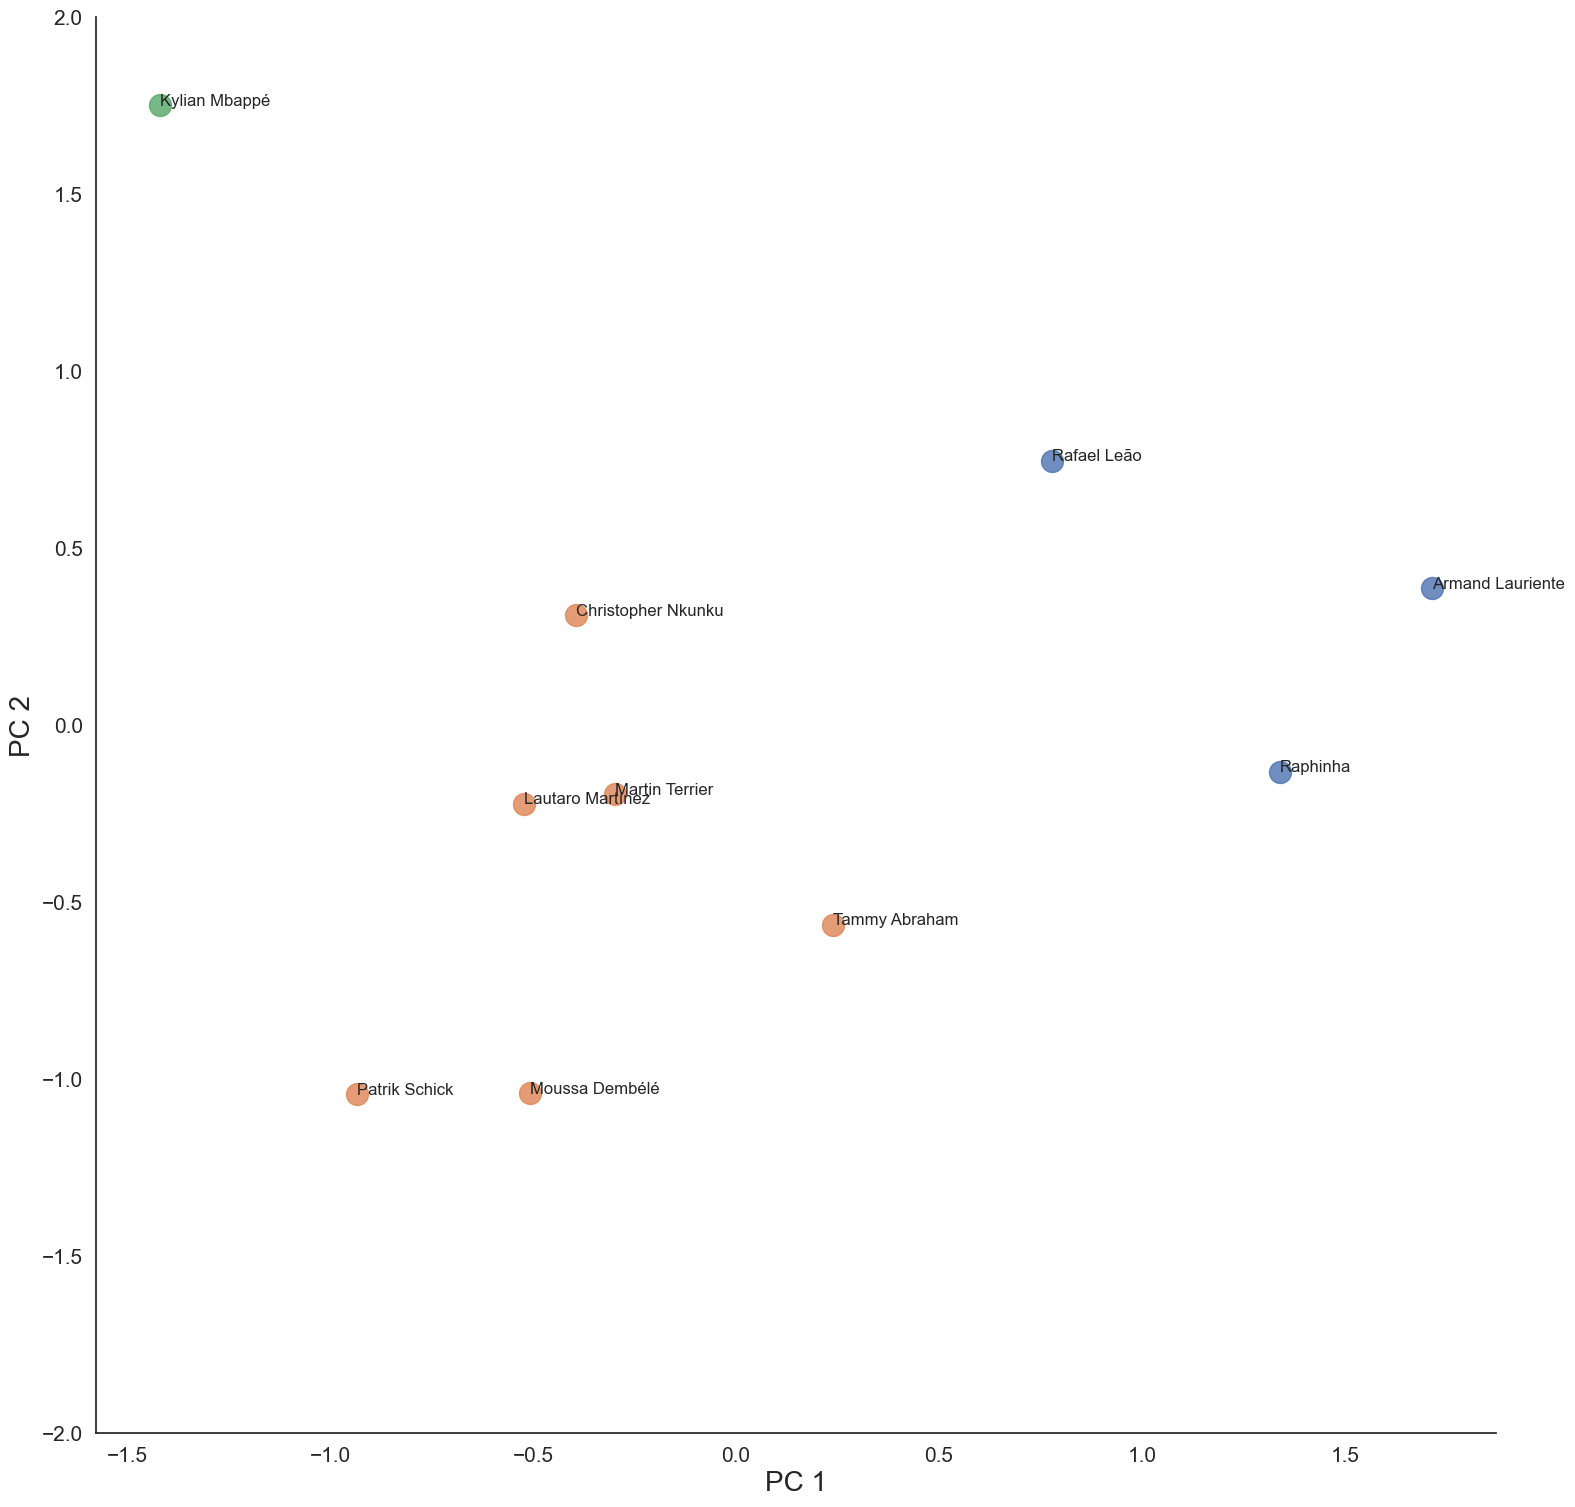

In [53]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = reduced, legend=False,
                   fit_reg=False, size = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

## Scout Pick: Christopher Nkunku

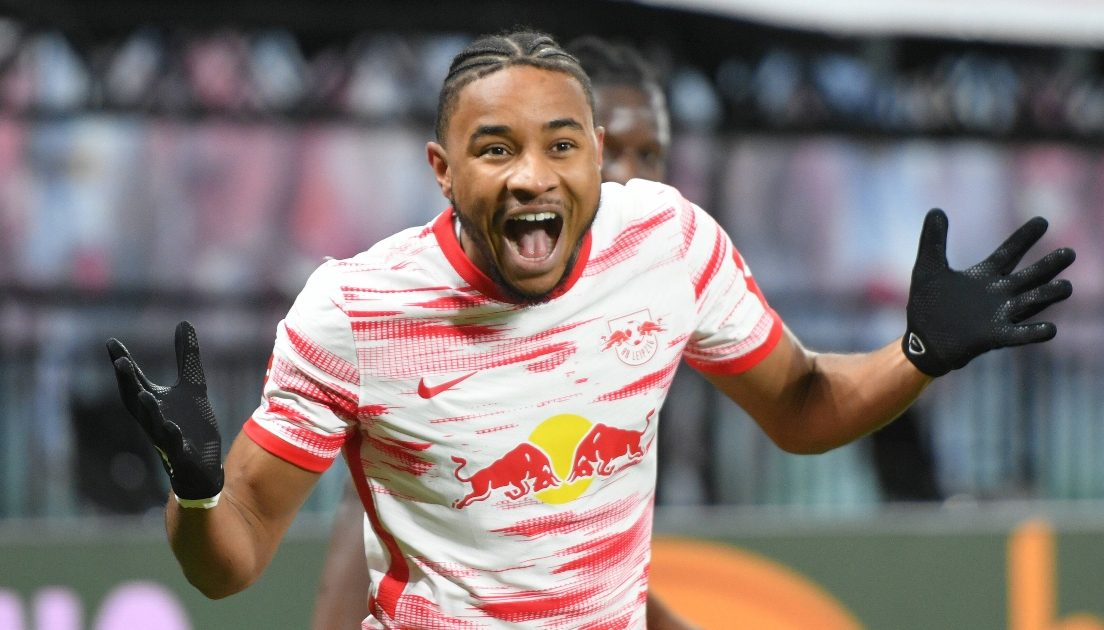

### Scraping data for Nkunku

In [54]:
nkunku_url = "https://fbref.com/en/players/7c56da38/Christopher-Nkunku"
nkdata = requests.get(nkunku_url)
soup = BeautifulSoup(nkdata.text)
table = soup.select('table.stats_table')[0]
table2 = soup.select('table.stats_table')[1]
table3 = soup.select('table.stats_table')[4]
nkunku1 = pd.read_html(nkdata.text, match="Standard Stats")[0]
nkunku2 = pd.read_html(nkdata.text, match="Shooting")[0]
nkunku3 = pd.read_html(nkdata.text, match="Goal and Shot Creation")[0]

In [55]:
nkunku1.columns = nkunku1.columns.droplevel(0)
nkunku2.columns = nkunku2.columns.droplevel(0)
nkunku3.columns = nkunku3.columns.droplevel(0)
nkunku1.drop(nkunku1.index[7:15], inplace=True)
nkunku2.drop(nkunku2.index[7:15], inplace=True)
nkunku3.drop(nkunku3.index[7:15], inplace=True)

In [56]:
del nkunku1["Matches"]
del nkunku1["LgRank"]

del nkunku2["Age"]
del nkunku2["Squad"]
del nkunku2["Country"]
del nkunku2["Comp"]
del nkunku2["LgRank"]
del nkunku2["90s"]
del nkunku2["Gls"]
del nkunku2["xG"]
del nkunku2["npxG"]
del nkunku2["Matches"]

del nkunku3["Age"]
del nkunku3["Squad"]
del nkunku3["Country"]
del nkunku3["Comp"]
del nkunku3["LgRank"]
del nkunku3["90s"]
del nkunku3["Sh"]
del nkunku3["Matches"]

In [57]:
nkunku = pd.merge(nkunku1, nkunku2, on ="Season",how="left")
nkunku = pd.merge(nkunku, nkunku3, on ="Season",how="left")

In [58]:
nkunku.drop([col for col in nkunku.columns if 'drop' in col], axis=1, inplace=True)

In [59]:
#Checking and deleting null data
print(nkunku.isnull().any().any(), nkunku.shape)
nkunku = nkunku.fillna(0)
print(nkunku.isnull().any().any(), nkunku.shape)

True (7, 58)
False (7, 58)


In [60]:
numeric = nkunku[['MP','Starts', 'Min','90s', 'Gls', 'Ast', 'G-PK', 'PK_x', 'PKatt_x', 'CrdY', 'CrdR', 'Gls', 'Ast', 'G+A',
 'G-PK', 'G+A-PK', 'xG', 'npxG', 'xA', 'npxG+xA', 'xG', 'xA', 'xG+xA', 'npxG', 'npxG+xA', 'Sh', 'SoT', 'SoT%',
 'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT', 'Dist', 'FK', 'PK_y', 'PKatt_y', 'npxG/Sh', 'G-xG', 'np:G-xG', 'SCA', 'SCA90',
 'PassLive', 'PassDead', 'Drib','Fld', 'Def', 'GCA', 'GCA90', 'PassLive', 'PassDead', 'Drib', 'Fld','Def']]

numeric = numeric.astype(float)
numeric['overall'] = numeric.mean(axis='columns')
numeric

MP  Starts     Min   90s   Gls   Gls   Ast   Ast  G-PK  G-PK  PK_x  \
0   5.0     4.0   328.0   3.6   0.0  0.00   0.0  0.00   0.0  0.00   0.0   
1   8.0     5.0   398.0   4.4   1.0  0.23   0.0  0.00   1.0  0.23   0.0   
2  20.0     6.0   631.0   7.0   4.0  0.57   0.0  0.00   4.0  0.57   0.0   
3  22.0    13.0  1156.0  12.8   3.0  0.23   2.0  0.16   3.0  0.23   0.0   
4  32.0    21.0  1925.0  21.4   5.0  0.23  13.0  0.61   5.0  0.23   0.0   
5  28.0    19.0  1892.0  21.0   6.0  0.29   6.0  0.29   6.0  0.29   0.0   
6  34.0    31.0  2723.0  30.3  20.0  0.66  13.0  0.43  19.0  0.63   1.0   

   PKatt_x  CrdY  CrdR   Gls   Gls   Ast   Ast   G+A  G-PK  G-PK  G+A-PK  \
0      0.0   0.0   0.0   0.0  0.00   0.0  0.00  0.00   0.0  0.00    0.00   
1      0.0   2.0   0.0   1.0  0.23   0.0  0.00  0.23   1.0  0.23    0.23   
2      0.0   0.0   0.0   4.0  0.57   0.0  0.00  0.57   4.0  0.57    0.57   
3      0.0   0.0   0.0   3.0  0.23   2.0  0.16  0.39   3.0  0.23    0.39   
4      0.0   2.0   0.0   5.0  0.23  13.0  0.61  0.84   5.0  0.23    0.84   
5      0.0   2.0   0.0   6.0  0.29   6.0  0.29  0.57   6.0  0.29    0.57   
6      1.0   2.0   0.0  20.0  0.66  13.0  0.43  1.09  19.0  0.63    1.06   

     xG    xG  npxG  npxG    xA    xA  npxG+xA  npxG+xA    xG    xG    xA  \
0   0.0  0.00   0.0  0.00   0.0  0.00      0.0     0.00   0.0  0.00   0.0   
1   0.0  0.00   0.0  0.00   0.0  0.00      0.0     0.00   0.0  0.00   0.0   
2   3.6  0.51   3.6  0.51   0.6  0.09      4.2     0.60   3.6  0.51   0.6   
3   2.3  0.18   2.3  0.18   3.3  0.26      5.6     0.43   2.3  0.18   3.3   
4   7.5  0.35   7.5  0.35   9.0  0.42     16.5     0.77   7.5  0.35   9.0   
5   7.8  0.37   7.8  0.37   7.5  0.36     15.3     0.73   7.8  0.37   7.5   
6  14.8  0.49  14.1  0.46  10.0  0.33     24.0     0.79  14.8  0.49  10.0   

     xA  xG+xA  npxG  npxG  npxG+xA  npxG+xA    Sh   SoT  SoT%  Sh/90  SoT/90  \
0  0.00   0.00   0.0  0.00      0.0     0.00   0.0   0.0   0.0   0.00    0.00   
1  0.00   0.00   0.0  0.00      0.0     0.00   7.0   2.0  28.6   1.58    0.45   
2  0.09   0.60   3.6  0.51      4.2     0.60  24.0  14.0  58.3   3.42    2.00   
3  0.26   0.43   2.3  0.18      5.6     0.43  22.0   5.0  22.7   1.71    0.39   
4  0.42   0.77   7.5  0.35     16.5     0.77  52.0  23.0  44.2   2.43    1.08   
5  0.36   0.73   7.8  0.37     15.3     0.73  56.0  26.0  46.4   2.66    1.24   
6  0.33   0.82  14.1  0.46     24.0     0.79  80.0  39.0  48.8   2.64    1.29   

   G/Sh  G/SoT  Dist   FK  PK_y  PKatt_y  npxG/Sh  G-xG  np:G-xG    SCA  \
0  0.00   0.00   0.0  0.0   0.0      0.0     0.00   0.0      0.0    0.0   
1  0.14   0.50   0.0  0.0   0.0      0.0     0.00   0.0      0.0    0.0   
2  0.17   0.29  14.6  0.0   0.0      0.0     0.15   0.4      0.4   20.0   
3  0.14   0.60  20.0  0.0   0.0      0.0     0.10   0.7      0.7   39.0   
4  0.10   0.22  17.8  3.0   0.0      0.0     0.14  -2.5     -2.5  107.0   
5  0.11   0.23  17.2  6.0   0.0      0.0     0.14  -1.8     -1.8  130.0   
6  0.24   0.49  15.7  7.0   1.0      1.0     0.18   5.2      4.9  134.0   

   SCA90  PassLive  PassLive  PassDead  PassDead  Drib  Drib   Fld  Fld  Def  \
0   0.00       0.0       0.0       0.0       0.0   0.0   0.0   0.0  0.0  0.0   
1   0.00       0.0       0.0       0.0       0.0   0.0   0.0   0.0  0.0  0.0   
2   2.85      15.0       1.0       1.0       0.0   0.0   0.0   1.0  0.0  0.0   
3   3.04      31.0       4.0       0.0       0.0   1.0   0.0   4.0  1.0  2.0   
4   5.00      60.0      12.0      29.0       5.0   7.0   1.0   6.0  1.0  2.0   
5   6.18      66.0      10.0      36.0       2.0   8.0   2.0  12.0  1.0  2.0   
6   4.43      84.0      18.0       9.0       0.0  15.0   3.0  13.0  4.0  3.0   

   Def   GCA  GCA90  PassLive  PassLive  PassDead  PassDead  Drib  Drib   Fld  \
0  0.0   0.0   0.00       0.0       0.0       0.0       0.0   0.0   0.0   0.0   
1  0.0   0.0   0.00       0.0       0.0       0.0       0.0   0.0   0.0   0.0   
2  0.0   1.0   0.14      15.0       1.0     

In [61]:
#Split ID as a Target value
target = numeric.overall
df2 = numeric.drop(['overall'], axis = 1)

#Splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(df2, target, test_size=0.2)

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
print(X_test.shape,X_train.shape)
print(y_test.shape,y_train.shape)

(2, 77) (5, 77)
(2,) (5,)


In [62]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

#Finding the r2 score and root mean squared error
print('r2 score: '+str(r2_score(y_test, predictions)))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test, predictions))))

r2 score: 0.9691543721046065
RMSE : 0.6531810881749214


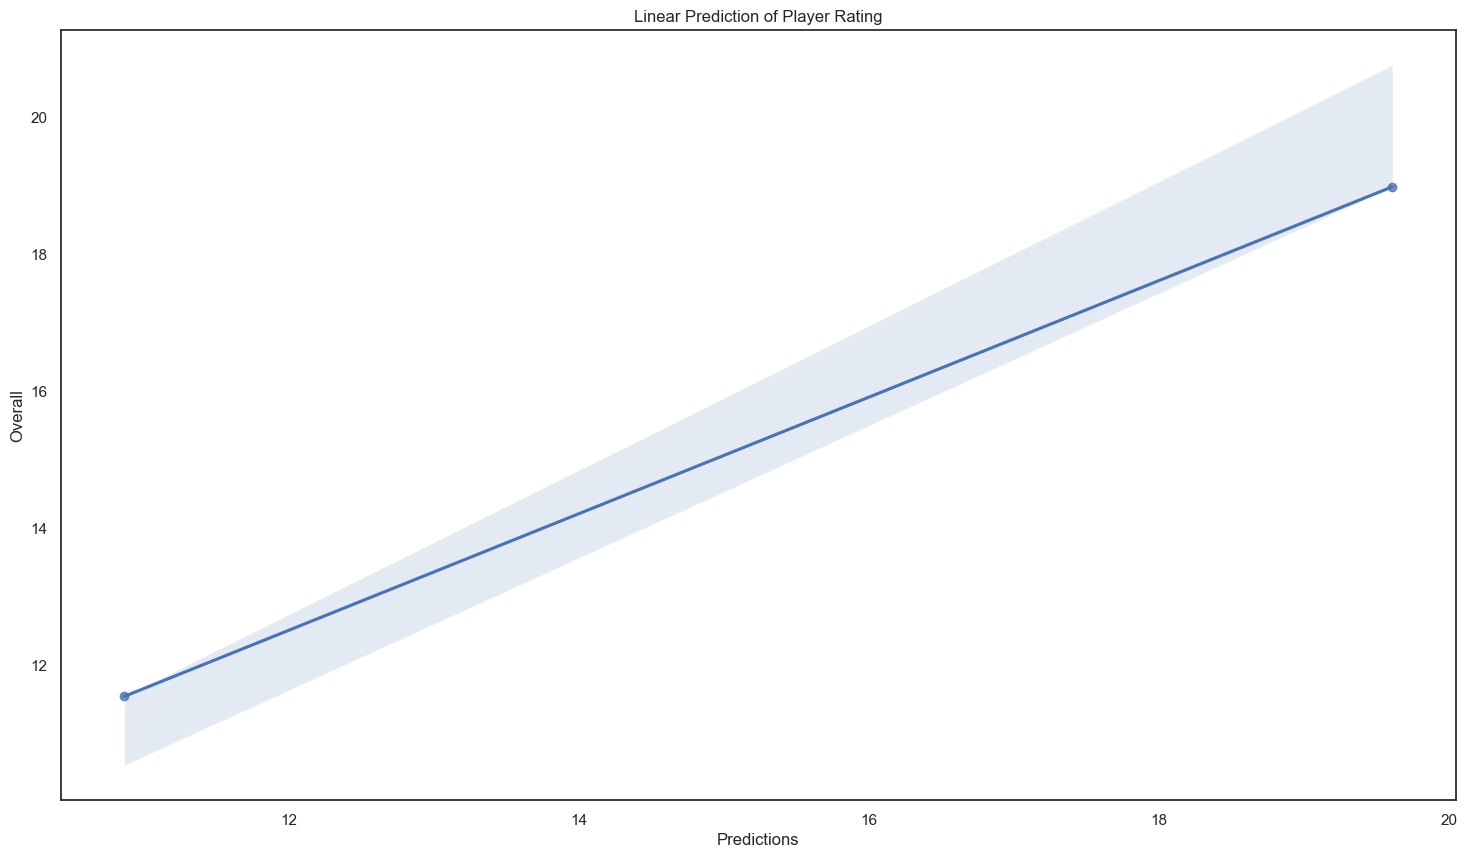

In [63]:
#Visualising the results
plt.figure(figsize=(18,10))
sns.regplot(predictions,y_test)
plt.xlabel('Predictions')
plt.ylabel('Overall')
plt.title("Linear Prediction of Player Rating")
plt.show()

# Defensive Player Scouting

In [64]:
defense_url = "https://fbref.com/en/comps/Big5/2021-2022/defense/players/2021-2022-Big-5-European-Leagues-Stats"

data = requests.get(defense_url)
soup = BeautifulSoup(data.text)
defense_table = soup.select('table.stats_table')[0]
defense = pd.read_html(data.text)[0]
defense.columns = defense.columns.droplevel()
time.sleep(1)

In [65]:
del defense["Rk"]
del defense["Matches"]

In [66]:
#dropping duplicate columns
defense = defense.drop(defense.iloc[:, 10:13],axis = 1)
defense = defense.drop(defense.iloc[:, 19:22],axis = 1)
defense

Player   Nation Pos          Squad                Comp Age  \
0            Max Aarons  eng ENG  DF   Norwich City  eng Premier League  21   
1      Yunis Abdelhamid   ma MAR  DF          Reims          fr Ligue 1  33   
2     Salis Abdul Samed   gh GHA  MF  Clermont Foot          fr Ligue 1  21   
3       Laurent Abergel   fr FRA  MF        Lorient          fr Ligue 1  28   
4           Charles Abi   fr FRA  FW  Saint-Étienne          fr Ligue 1  21   
...                 ...      ...  ..            ...                 ...  ..   
3032         Kurt Zouma   fr FRA  DF       West Ham  eng Premier League  26   
3033        Petar Zovko   ba BIH  GK         Spezia          it Serie A  19   
3034      Igor Zubeldia   es ESP  DF  Real Sociedad          es La Liga  24   
3035   Martín Zubimendi   es ESP  MF  Real Sociedad          es La Liga  22   
3036   Szymon Żurkowski   pl POL  MF         Empoli          it Serie A  23   

      Born   90s  Tkl TklW Tkl  Att  Tkl% Past Press Succ     % Blocks  Sh  \
0     2000  32.0   69   37  37   58  63.8   21   434  113  26.0     86  22   
1     1987  33.1   62   46  13   27  48.1   14   451  162  35.9     62  26   
2     2000  27.4   55   34  19   59  32.2   40   641  179  27.9     27   1   
3     1993  32.8  117   73  59  163  36.2  104   918  259  28.2     55   3   
4     2000   0.5    0    0   0    1   0.0    1    14    1   7.1      1   0   
...    ...   ...  ...  ...  ..  ...   ...  ...   ...  ...   ...    ...  ..   
3032  1994  23.1   11    5   4    8  50.0    4   107   35  32.7     38  27   
3033  2002   0.3    0    0   0    0   NaN    0     0    0   NaN      0   0   
3034  1997  18.3   26   15  13   21  61.9    8   155   48  31.0     27   9   
3035  1999  28.8   61   32  22   40  55.0   18   394  129  32.7     39  14   
3036  1997  25.6   71   49  20   52  38.5   32   477  140  29.4     52  11   

     Tkl+Int  Clr Err  
0        125   69   0  
1        165  106   0  
2        106   15   0  
3        201   11   0  
4          0    0   0  
...      ...  ...  ..  
3032      58  140   0  
3033       0    0   0  
3034      57   63   0  
3035     111   64   0  
3036     128   30   2  

[3037 rows x 22 columns]

In [67]:
defense["Player"] = defense["Player"].astype('str') 
defense["Nation"] = defense["Nation"].astype('str') 
defense["Pos"] = defense["Pos"].astype('str') 
defense["Squad"] = defense["Squad"].astype('str') 
defense["Comp"] = defense["Comp"].astype('str') 
defense["Age"] = defense["Age"].apply(pd.to_numeric, errors='coerce')
defense["Born"] = defense["Born"].apply(pd.to_numeric, errors='coerce')
defense["90s"] = defense["90s"].apply(pd.to_numeric, errors='coerce')
defense["Tkl"] = defense["Tkl"].apply(pd.to_numeric, errors='coerce')
defense["TklW"] = defense["TklW"].apply(pd.to_numeric, errors='coerce')
defense["Tkl"] = defense["Tkl"].apply(pd.to_numeric, errors='coerce')
defense["Att"] = defense["Att"].apply(pd.to_numeric, errors='coerce')
defense["Tkl%"] = defense["Tkl%"].apply(pd.to_numeric, errors='coerce')
defense["Past"] = defense["Past"].apply(pd.to_numeric, errors='coerce')
defense["Press"] = defense["Press"].apply(pd.to_numeric, errors='coerce')
defense["Succ"] = defense["Succ"].apply(pd.to_numeric, errors='coerce')
defense["%"] = defense["%"].apply(pd.to_numeric, errors='coerce')
defense["Blocks"] = defense["Blocks"].apply(pd.to_numeric, errors='coerce')
defense["Sh"] = defense["Sh"].apply(pd.to_numeric, errors='coerce')
defense["Tkl+Int"] = defense["Tkl+Int"].apply(pd.to_numeric, errors='coerce')
defense["Clr"] = defense["Clr"].apply(pd.to_numeric, errors='coerce')
defense["Err"] = defense["Err"].apply(pd.to_numeric, errors='coerce')

defense.dtypes

Player      object
Nation      object
Pos         object
Squad       object
Comp        object
Age        float64
Born       float64
90s        float64
Tkl        float64
TklW       float64
Tkl        float64
Att        float64
Tkl%       float64
Past       float64
Press      float64
Succ       float64
%          float64
Blocks     float64
Sh         float64
Tkl+Int    float64
Clr        float64
Err        float64
dtype: object

In [68]:
#Checking and deleting null data
print(defense.isnull().any().any(), defense.shape)

rows = defense.shape[0]

# Drop the NULL rows
defense = defense.fillna(defense.mean())

print(defense.isnull().any().any(), defense.shape)

#Checking for duplicates and dropping them
defense = defense.drop_duplicates()
print(sum(defense.duplicated()))

True (3037, 22)
False (3037, 22)
0


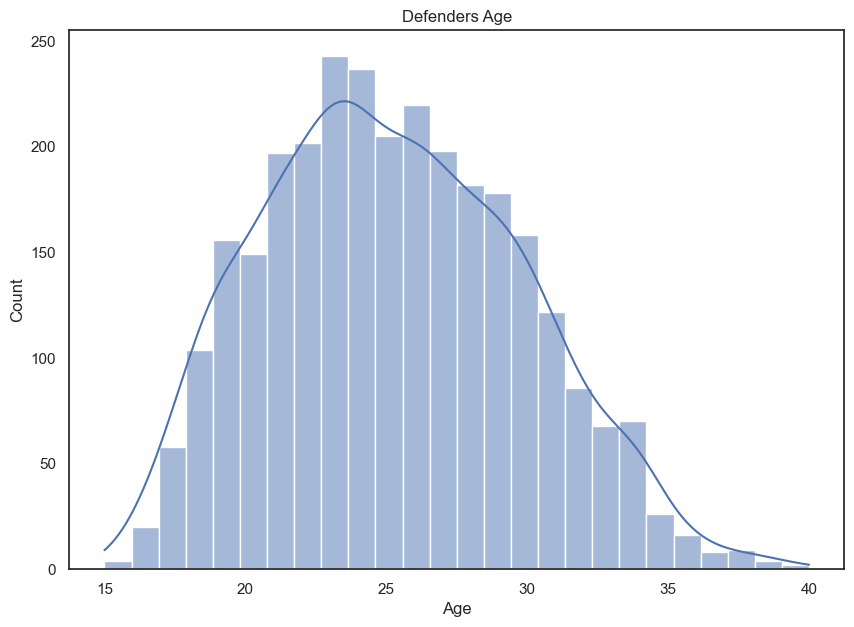

In [69]:
# For the signing of a Center back for XXXX we will require a player with expertise that can not only set captain
# the team if needed, provide experience and be a guide for the younger players.

# This team will need someone aged 27-35 that has had experience in the league and that has attitude of a leader
# with winning mentality

plt.figure(figsize = (10, 7))
sns.histplot(defense['Age'], kde = True)
plt.title('Defenders Age')
plt.show()

In [70]:
Dshortlist = pd.DataFrame
Dshortlist = defense.loc[(defense.Age > 27) & (defense.Age < 35)]
Dshortlist = Dshortlist.loc[Dshortlist.Comp == "eng Premier League"]
Dshortlist = Dshortlist[Dshortlist.Pos == "DF"]
Dshortlist.index = range(Dshortlist.shape[0])
Dshortlist

Player   Nation Pos            Squad                Comp  \
0          Marcos Alonso   es ESP  DF          Chelsea  eng Premier League   
1            Luke Ayling  eng ENG  DF     Leeds United  eng Premier League   
2      César Azpilicueta   es ESP  DF          Chelsea  eng Premier League   
3          Ryan Bertrand  eng ENG  DF   Leicester City  eng Premier League   
4             Willy Boly   ci CIV  DF           Wolves  eng Premier League   
..                   ...      ...  ..              ...                 ...   
58          Joël Veltman   nl NED  DF         Brighton  eng Premier League   
59    Jannik Vestergaard   dk DEN  DF   Leicester City  eng Premier League   
60           Kyle Walker  eng ENG  DF  Manchester City  eng Premier League   
61             Joel Ward  eng ENG  DF   Crystal Palace  eng Premier League   
62  Christoph Zimmermann   de GER  DF     Norwich City  eng Premier League   

     Age    Born   90s   Tkl  TklW   Tkl    Att  Tkl%  Past  Press   Succ  \
0   30.0  1990.0  24.1  45.0  28.0  14.0   32.0  43.8  18.0  300.0   85.0   
1   29.0  1991.0  25.2  79.0  45.0  49.0  101.0  48.5  52.0  392.0  137.0   
2   31.0  1989.0  23.0  54.0  31.0  21.0   43.0  48.8  22.0  356.0  104.0   
3   31.0  1989.0   3.7   9.0   4.0   4.0    5.0  80.0   1.0   75.0   25.0   
4   30.0  1991.0  10.0  27.0  22.0   8.0   15.0  53.3   7.0  110.0   43.0   
..   ...     ...   ...   ...   ...   ...    ...   ...   ...    ...    ...   
58  29.0  1992.0  31.9  90.0  40.0  31.0   64.0  48.4  33.0  350.0  110.0   
59  28.0  1992.0   6.3  16.0  11.0   6.0   15.0  40.0   9.0   60.0   22.0   
60  31.0  1990.0  19.5  23.0  16.0  11.0   22.0  50.0  11.0  164.0   56.0   
61  31.0  1989.0  27.6  48.0  28.0  24.0   51.0  47.1  27.0  284.0   84.0   
62  28.0  1993.0   1.7   5.0   3.0   2.0    4.0  50.0   2.0   24.0    9.0   

       %  Blocks    Sh  Tkl+Int    Clr  Err  
0   28.3    39.0   6.0    111.0   55.0  0.0  
1   34.9    49.0  28.0    133.0   68.0  1.0  
2   29.2    62.0  11.0     91.0   71.0  1.0  
3   33.3    11.0   3.0     12.0    7.0  0.0  
4   39.1    21.0   7.0     46.0   39.0  0.0  
..   ...     ...   ...      ...    ...  ...  
58  31.4    65.0  16.0    157.0   97.0  1.0  
59  36.7    15.0  10.0     31.0   41.0  1.0  
60  34.1    20.0   4.0     48.0   24.0  0.0  
61  29.6    53.0  12.0    102.0  102.0  1.0  
62  37.5     0.0   0.0      8.0    3.0  0.0  

[63 rows x 22 columns]

In [71]:
# Getting an overall rating 
overall = pd.DataFrame
overall = Dshortlist
overall['average'] = overall.mean(axis='columns')

overall.sort_values(by=['average'], ascending=False)
overall = overall.nlargest(n=10, columns=['average'], keep='all')
overall

Player   Nation Pos         Squad                Comp   Age  \
1         Luke Ayling  eng ENG  DF  Leeds United  eng Premier League  29.0   
52    James Tarkowski  eng ENG  DF       Burnley  eng Premier League  28.0   
58       Joël Veltman   nl NED  DF      Brighton  eng Premier League  29.0   
28       Grant Hanley  sct SCO  DF  Norwich City  eng Premier League  29.0   
49       Romain Saïss   ma MAR  DF        Wolves  eng Premier League  31.0   
11     Séamus Coleman   ie IRL  DF       Everton  eng Premier League  32.0   
45      Ethan Pinnock   jm JAM  DF     Brentford  eng Premier League  28.0   
2   César Azpilicueta   es ESP  DF       Chelsea  eng Premier League  31.0   
33      Michael Keane  eng ENG  DF       Everton  eng Premier League  28.0   
48    Antonio Rüdiger   de GER  DF       Chelsea  eng Premier League  28.0   

      Born   90s   Tkl  TklW   Tkl    Att  Tkl%  Past  Press   Succ     %  \
1   1991.0  25.2  79.0  45.0  49.0  101.0  48.5  52.0  392.0  137.0  34.9   
52  1992.0  34.5  71.0  42.0  32.0   57.0  56.1  25.0  261.0   94.0  36.0   
58  1992.0  31.9  90.0  40.0  31.0   64.0  48.4  33.0  350.0  110.0  31.4   
28  1991.0  32.2  55.0  38.0  14.0   29.0  48.3  15.0  269.0  102.0  37.9   
49  1990.0  30.1  60.0  38.0  18.0   32.0  56.3  14.0  283.0  103.0  36.4   
11  1988.0  29.5  72.0  42.0  29.0   47.0  61.7  18.0  336.0  124.0  36.9   
45  1993.0  29.9  63.0  38.0  20.0   36.0  55.6  16.0  281.0  102.0  36.3   
2   1989.0  23.0  54.0  31.0  21.0   43.0  48.8  22.0  356.0  104.0  29.2   
33  1993.0  31.0  49.0  35.0  25.0   43.0  58.1  18.0  228.0   93.0  40.8   
48  1993.0  33.7  53.0  28.0  30.0   46.0  65.2  16.0  294.0   92.0  31.3   

    Blocks    Sh  Tkl+Int    Clr  Err     average  
1     49.0  28.0    133.0   68.0  1.0  191.917647  
52    92.0  63.0    143.0  216.0  5.0  191.035294  
58    65.0  16.0    157.0   97.0  1.0  187.452941  
28    77.0  54.0    120.0  196.0  1.0  182.847059  
49    61.0  24.0    141.0  173.0  1.0  181.870588  
11    59.0  13.0    126.0   75.0  1.0  181.770588  
45    49.0  13.0    119.0  175.0  1.0  179.752941  
2     62.0  11.0     91.0   71.0  1.0  175.764706  
33    51.0  32.0    111.0  149.0  2.0  175.700000  
48    41.0  13.0     96.0  110.0  1.0  174.776471

In [72]:
Dnumeric = overall.iloc[:, 5:]
Dnumeric

Age    Born   90s   Tkl  TklW   Tkl    Att  Tkl%  Past  Press   Succ  \
1   29.0  1991.0  25.2  79.0  45.0  49.0  101.0  48.5  52.0  392.0  137.0   
52  28.0  1992.0  34.5  71.0  42.0  32.0   57.0  56.1  25.0  261.0   94.0   
58  29.0  1992.0  31.9  90.0  40.0  31.0   64.0  48.4  33.0  350.0  110.0   
28  29.0  1991.0  32.2  55.0  38.0  14.0   29.0  48.3  15.0  269.0  102.0   
49  31.0  1990.0  30.1  60.0  38.0  18.0   32.0  56.3  14.0  283.0  103.0   
11  32.0  1988.0  29.5  72.0  42.0  29.0   47.0  61.7  18.0  336.0  124.0   
45  28.0  1993.0  29.9  63.0  38.0  20.0   36.0  55.6  16.0  281.0  102.0   
2   31.0  1989.0  23.0  54.0  31.0  21.0   43.0  48.8  22.0  356.0  104.0   
33  28.0  1993.0  31.0  49.0  35.0  25.0   43.0  58.1  18.0  228.0   93.0   
48  28.0  1993.0  33.7  53.0  28.0  30.0   46.0  65.2  16.0  294.0   92.0   

       %  Blocks    Sh  Tkl+Int    Clr  Err     average  
1   34.9    49.0  28.0    133.0   68.0  1.0  191.917647  
52  36.0    92.0  63.0    143.0  216.0  5.0  191.035294  
58  31.4    65.0  16.0    157.0   97.0  1.0  187.452941  
28  37.9    77.0  54.0    120.0  196.0  1.0  182.847059  
49  36.4    61.0  24.0    141.0  173.0  1.0  181.870588  
11  36.9    59.0  13.0    126.0   75.0  1.0  181.770588  
45  36.3    49.0  13.0    119.0  175.0  1.0  179.752941  
2   29.2    62.0  11.0     91.0   71.0  1.0  175.764706  
33  40.8    51.0  32.0    111.0  149.0  2.0  175.700000  
48  31.3    41.0  13.0     96.0  110.0  1.0  174.776471

In [73]:
# Plotting a K-Means Cluster

x = Dnumeric.values # numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

pca = PCA(n_components = 2) # 2D PCA for the plot
reduced = pd.DataFrame(pca.fit_transform(X_norm))

# specify the number of clusters
kmeans = KMeans(n_clusters=4)

# fit the input data
kmeans = kmeans.fit(reduced)

# get the cluster labels
labels = kmeans.predict(reduced)

# centroid values
centroid = kmeans.cluster_centers_

# cluster values
clusters = kmeans.labels_.tolist()

#plot it
names = overall.Player.tolist() 
reduced['cluster'] = clusters
reduced['name'] = names
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced.head()

x         y  cluster             name
0  1.691484  0.373443        1      Luke Ayling
1 -0.427291  1.523331        2  James Tarkowski
2  0.798178  0.370960        1     Joël Veltman
3 -0.603732  0.395744        0     Grant Hanley
4 -0.247746 -0.129631        0     Romain Saïss

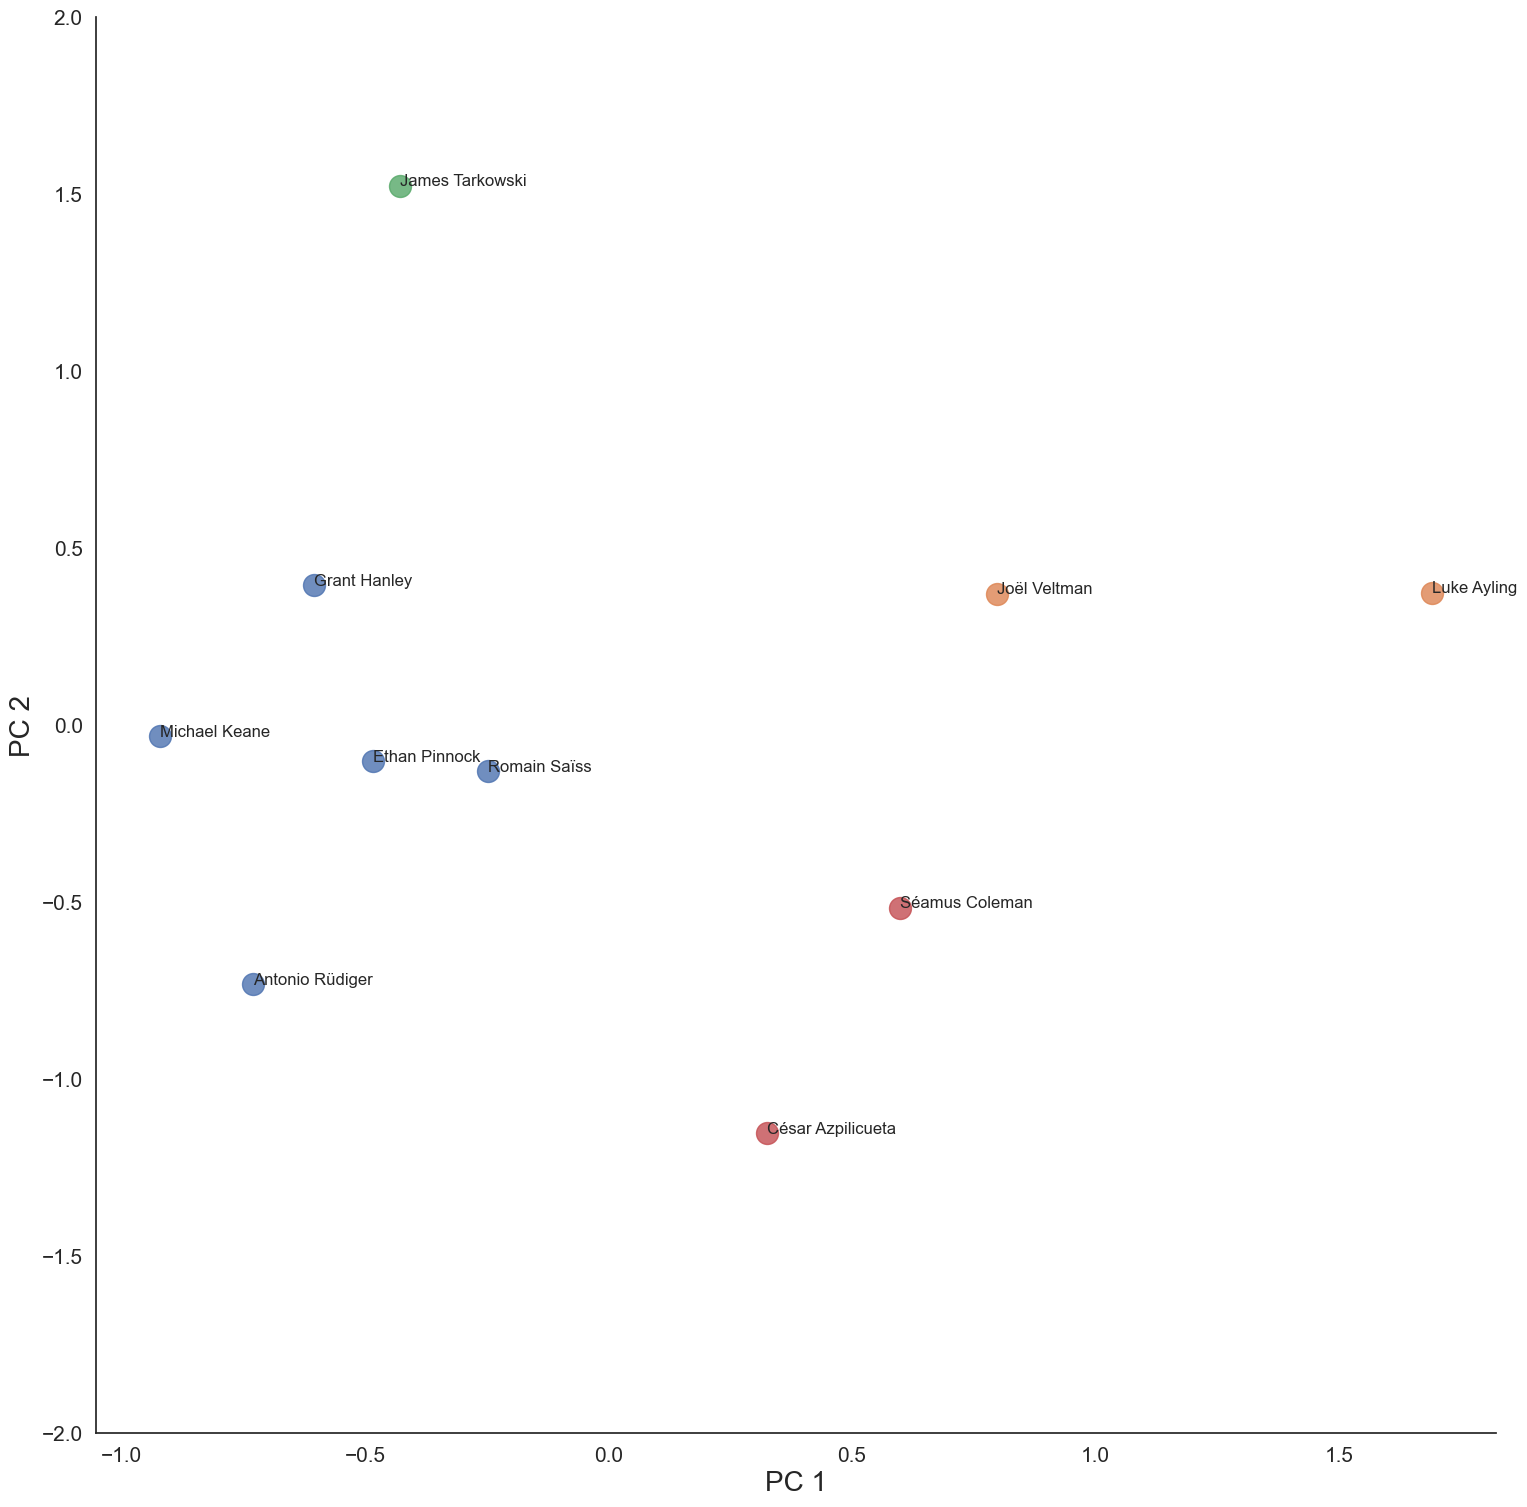

In [74]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = reduced, legend=False,
                   fit_reg=False, size = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

## Top Pick: Luke Ayling

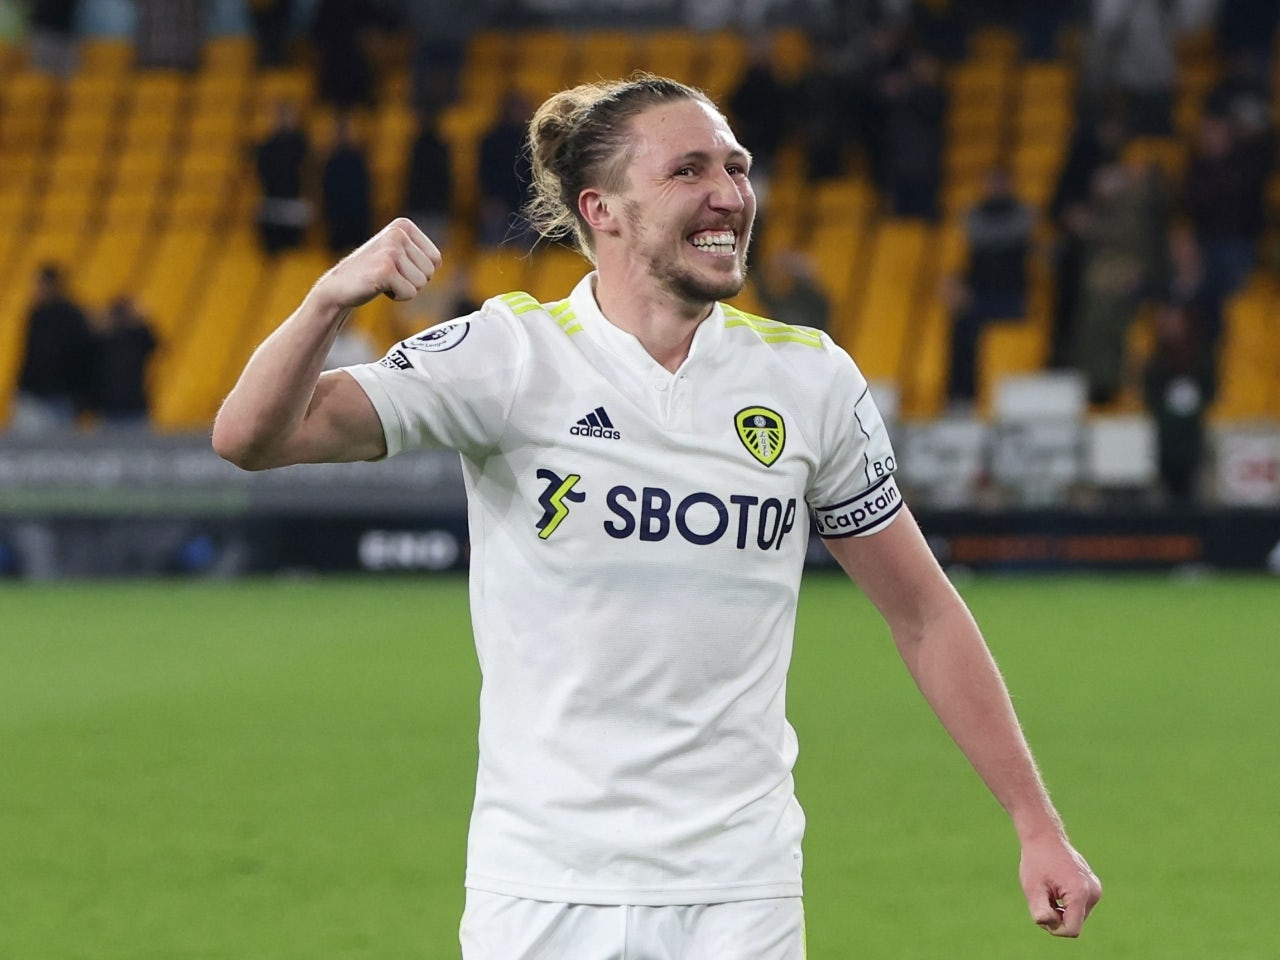

In [75]:
ayling_url = "https://fbref.com/en/players/420d7c7d/Luke-Ayling"
aydata = requests.get(ayling_url)
soup = BeautifulSoup(aydata.text)
table = soup.select('table.stats_table')[0]
table2 = soup.select('table.stats_table')[5]
ayling1 = pd.read_html(aydata.text, match="Standard Stats")[0]
ayling2 = pd.read_html(aydata.text, match="Defensive Actions")[0]

In [76]:
ayling1.columns = ayling1.columns.droplevel(0)
ayling2.columns = ayling2.columns.droplevel(0)
ayling1.drop(ayling1.index[15:27], inplace=True)
ayling2.drop(ayling2.index[15:27], inplace=True)

In [77]:
del ayling1["Matches"]
del ayling1["LgRank"]

del ayling2["Age"]
del ayling2["Squad"]
del ayling2["Country"]
del ayling2["Comp"]
del ayling2["LgRank"]
del ayling2["90s"]
del ayling2["Matches"]

In [78]:
ayling = pd.merge(ayling1, ayling2, on ="Season",how="left")

In [79]:
ayling.drop([col for col in nkunku.columns if 'drop' in col], axis=1, inplace=True)
ayling.drop(ayling.index[19:22], inplace=True)

In [80]:
#Checking and deleting null data
print(ayling.isnull().any().any(), ayling.shape)
ayling = ayling.fillna(0)
print(ayling.isnull().any().any(), ayling.shape)

True (19, 53)
False (19, 53)


In [81]:
ayling

Season Age          Squad  Country               Comp  MP Starts   Min  \
0   2009-2010  17    Yeovil Town  eng ENG      3. League One   4      1   144   
1   2010-2011  18    Yeovil Town  eng ENG      3. League One  37     31  2789   
2   2011-2012  19    Yeovil Town  eng ENG      3. League One  44     44  3954   
3   2012-2013  20    Yeovil Town  eng ENG      3. League One  39     38  3400   
4   2013-2014  21    Yeovil Town  eng ENG    2. Championship  42     41  3742   
5   2014-2015  22   Bristol City  eng ENG      3. League One  46     46  4080   
6   2015-2016  23   Bristol City  eng ENG    2. Championship  33     29  2652   
7   2016-2017  24   Bristol City  eng ENG    2. Championship   1      1    90   
8   2016-2017  24   Bristol City  eng ENG    2. Championship   1      1    90   
9   2016-2017  24   Leeds United  eng ENG    2. Championship  42     42  3761   
10  2016-2017  24   Leeds United  eng ENG    2. Championship  42     42  3761   
11  2017-2018  25   Leeds United  eng ENG    2. Championship  27     27  2365   
12  2018-2019  26   Leeds United  eng ENG    2. Championship  38     38  3238   
13  2019-2020  27   Leeds United  eng ENG    2. Championship  37     35  3176   
14  2020-2021  28   Leeds United  eng ENG  1. Premier League  38     38  3399   
15  2021-2022  29  Leeds Utd U23  eng ENG   Jr. PL2 — Div. 1   1      1    45   
16  2021-2022  29  Leeds Utd U23  eng ENG   Jr. PL2 — Div. 1   1      1    45   
17  2021-2022  29   Leeds United  eng ENG  1. Premier League  26     26  2272   
18  2021-2022  29   Leeds United  eng ENG  1. Premier League  26     26  2272   

     90s Gls Ast G-PK PK PKatt CrdY CrdR   Gls   Ast   G+A  G-PK G+A-PK   xG  \
0    1.6   0   0    0  0     0    2    0  0.00  0.00  0.00  0.00   0.00    0   
1   31.0   0   1    0  0     0   13    2  0.00  0.03  0.03  0.00   0.03    0   
2   43.9   0   5    0  0     0    9    1  0.00  0.11  0.11  0.00   0.11    0   
3   37.8   0   3    0  0     0    4    0  0.00  0.08  0.08  0.00   0.08    0   
4   41.6   2   4    2  0     0    7    0  0.05  0.10  0.14  0.05   0.14    0   
5   45.3   4   2    4  0     0    3    0  0.09  0.04  0.13  0.09   0.13    0   
6   29.5   0   2    0  0     0    3    0  0.00  0.07  0.07  0.00   0.07    0   
7    1.0   0   0    0  0     0    0    0  0.00  0.00  0.00  0.00   0.00    0   
8    1.0   0   0    0  0     0    0    0  0.00  0.00  0.00  0.00   0.00    0   
9   41.8   0   3    0  0     0   10    0  0.00  0.07  0.07  0.00   0.07    0   
10  41.8   0   3    0  0     0   10    0  0.00  0.07  0.07  0.00   0.07    0   
11  26.3   0   1    0  0     0    4    0  0.00  0.04  0.04  0.00   0.04    0   
12  36.0   2   6    2  0     0    5    1  0.06  0.17  0.22  0.06   0.22    0   
13  35.3   4   4    4  0     0    9    0  0.11  0.11  0.23  0.11   0.23    0   
14  37.8   0   0    0  0     0    7    0  0.00  0.00  0.00  0.00   0.00  1.4   
15   0.5   0   0    0  0     0    0    0  0.00  0.00  0.00  0.00   0.00    0   
16   0.5   0   0    0  0     0    0    0  0.00  0.00  0.00  0.00   0.00    0   
17  25.2   2   2    2  0     0    4    1  0.08  0.08  0.16  0.08   0.16  1.7   
18  25.2   2   2    2  0     0    4    1  0.08  0.08  0.16  0.08   0.16  1.7   

   npxG   xA npxG+xA    xG    xA xG+xA  npxG npxG+xA  Tkl TklW Def 3rd  \
0     0    0       0     0     0     0     0       0    0    0       0   
1     0    0       0     0     0     0     0       0    0    0       0   
2     0    0       0     0     0     0     0       0    0    0       0   
3     0    0       0     0     0     0     0       0    0    0       0   
4     0    0       0     0     0     0     0       0    0    0       0   
5     0    0       0     0     0     0     0       0    0    0       0   
6     0    0       0     0     0     0     0       0    0    0       0   
7     0    0       0     0     0     0     0       0    0    0       0   
8     0    0       0     0     0     0     0       0    0    0       0   
9     0    0       0     0     0     0     0 

In [82]:
numeric = ayling[['MP', 'Starts', 'Min',
       '90s', 'Gls', 'Ast', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls',
       'Ast', 'G+A', 'G-PK', 'G+A-PK', 'xG', 'npxG', 'xA', 'npxG+xA', 'xG',
       'xA', 'xG+xA', 'npxG', 'npxG+xA', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd',
       'Att 3rd', 'Tkl', 'Att', 'Tkl%', 'Past', 'Press', 'Succ', '%',
       'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Blocks', 'Sh', 'ShSv', 'Pass', 'Int',
       'Tkl+Int', 'Clr', 'Err']]

numeric = numeric.astype(float)
numeric['overall'] = numeric.mean(axis='columns')
numeric

MP  Starts     Min   90s  Gls   Gls  Ast   Ast  G-PK  G-PK   PK  PKatt  \
0    4.0     1.0   144.0   1.6  0.0  0.00  0.0  0.00   0.0  0.00  0.0    0.0   
1   37.0    31.0  2789.0  31.0  0.0  0.00  1.0  0.03   0.0  0.00  0.0    0.0   
2   44.0    44.0  3954.0  43.9  0.0  0.00  5.0  0.11   0.0  0.00  0.0    0.0   
3   39.0    38.0  3400.0  37.8  0.0  0.00  3.0  0.08   0.0  0.00  0.0    0.0   
4   42.0    41.0  3742.0  41.6  2.0  0.05  4.0  0.10   2.0  0.05  0.0    0.0   
5   46.0    46.0  4080.0  45.3  4.0  0.09  2.0  0.04   4.0  0.09  0.0    0.0   
6   33.0    29.0  2652.0  29.5  0.0  0.00  2.0  0.07   0.0  0.00  0.0    0.0   
7    1.0     1.0    90.0   1.0  0.0  0.00  0.0  0.00   0.0  0.00  0.0    0.0   
8    1.0     1.0    90.0   1.0  0.0  0.00  0.0  0.00   0.0  0.00  0.0    0.0   
9   42.0    42.0  3761.0  41.8  0.0  0.00  3.0  0.07   0.0  0.00  0.0    0.0   
10  42.0    42.0  3761.0  41.8  0.0  0.00  3.0  0.07   0.0  0.00  0.0    0.0   
11  27.0    27.0  2365.0  26.3  0.0  0.00  1.0  0.04   0.0  0.00  0.0    0.0   
12  38.0    38.0  3238.0  36.0  2.0  0.06  6.0  0.17   2.0  0.06  0.0    0.0   
13  37.0    35.0  3176.0  35.3  4.0  0.11  4.0  0.11   4.0  0.11  0.0    0.0   
14  38.0    38.0  3399.0  37.8  0.0  0.00  0.0  0.00   0.0  0.00  0.0    0.0   
15   1.0     1.0    45.0   0.5  0.0  0.00  0.0  0.00   0.0  0.00  0.0    0.0   
16   1.0     1.0    45.0   0.5  0.0  0.00  0.0  0.00   0.0  0.00  0.0    0.0   
17  26.0    26.0  2272.0  25.2  2.0  0.08  2.0  0.08   2.0  0.08  0.0    0.0   
18  26.0    26.0  2272.0  25.2  2.0  0.08  2.0  0.08   2.0  0.08  0.0    0.0   

    CrdY  CrdR  Gls   Gls  Ast   Ast   G+A  G-PK  G-PK  G+A-PK   xG    xG  \
0    2.0   0.0  0.0  0.00  0.0  0.00  0.00   0.0  0.00    0.00  0.0  0.00   
1   13.0   2.0  0.0  0.00  1.0  0.03  0.03   0.0  0.00    0.03  0.0  0.00   
2    9.0   1.0  0.0  0.00  5.0  0.11  0.11   0.0  0.00    0.11  0.0  0.00   
3    4.0   0.0  0.0  0.00  3.0  0.08  0.08   0.0  0.00    0.08  0.0  0.00   
4    7.0   0.0  2.0  0.05  4.0  0.10  0.14   2.0  0.05    0.14  0.0  0.00   
5    3.0   0.0  4.0  0.09  2.0  0.04  0.13   4.0  0.09    0.13  0.0  0.00   
6    3.0   0.0  0.0  0.00  2.0  0.07  0.07   0.0  0.00    0.07  0.0  0.00   
7    0.0   0.0  0.0  0.00  0.0  0.00  0.00   0.0  0.00    0.00  0.0  0.00   
8    0.0   0.0  0.0  0.00  0.0  0.00  0.00   0.0  0.00    0.00  0.0  0.00   
9   10.0   0.0  0.0  0.00  3.0  0.07  0.07   0.0  0.00    0.07  0.0  0.00   
10  10.0   0.0  0.0  0.00  3.0  0.07  0.07   0.0  0.00    0.07  0.0  0.00   
11   4.0   0.0  0.0  0.00  1.0  0.04  0.04   0.0  0.00    0.04  0.0  0.00   
12   5.0   1.0  2.0  0.06  6.0  0.17  0.22   2.0  0.06    0.22  0.0  0.00   
13   9.0   0.0  4.0  0.11  4.0  0.11  0.23   4.0  0.11    0.23  0.0  0.00   
14   7.0   0.0  0.0  0.00  0.0  0.00  0.00   0.0  0.00    0.00  1.4  0.04   
15   0.0   0.0  0.0  0.00  0.0  0.00  0.00   0.0  0.00    0.00  0.0  0.00   
16   0.0   0.0  0.0  0.00  0.0  0.00  0.00   0.0  0.00    0.00  0.0  0.00   
17   4.0   1.0  2.0  0.08  2.0  0.08  0.16   2.0  0.08    0.16  1.7  0.07   
18   4.0   1.0  2.0  0.08  2.0  0.08  0.16   2.0  0.08    0.16  1.7  0.07   

    npxG  npxG   xA    xA  npxG+xA  npxG+xA   xG    xG   xA    xA  xG+xA  \
0    0.0  0.00  0.0  0.00      0.0      0.0  0.0  0.00  0.0  0.00    0.0   
1    0.0  0.00  0.0  0.00      0.0      0.0  0.0  0.00  0.0  0.00    0.0   
2    0.0  0.00  0.0  0.00      0.0      0.0  0.0  0.00  0.0  0.00    0.0   
3    0.0  0.00  0.0  0.00      0.0      0.0  0.0  0.00  0.0  0.00    0.0   
4    0.0  0.00  0.0  0.00      0.0      0.0  0.0  0.00  0.0  0.00    0.0   
5    0.0  0.00  0.0  0.00      0.0      0.0  0.0  0.00  0.0  0.00    0.0   
6    0.0  0.00  0.0  0.00      0.0      0.0  0.0  0.00  0.0  0.00    0.0   
7    0.0  0.00  0.0  0.00      0.0      0.0  0.0  0.00  0.0  0.00    0.0   
8    0.0  0.00  0.0  0.00      0.0      0.0  0.0  0.00  0.0  0.00    0.0   
9    0.0  0.00  0.0  0.00      0.0      0.0  0.0  0.00  0.0  0.00    0.0   
10   0.0  0.00  0.0  0.00   

In [83]:
#Split ID as a Target value
target = numeric.overall
df2 = numeric.drop(['overall'], axis = 1)

#Splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(df2, target, test_size=0.2)

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
print(X_test.shape,X_train.shape)
print(y_test.shape,y_train.shape)

(4, 70) (15, 70)
(4,) (15,)


In [84]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

#Finding the r2 score and root mean squared error
print('r2 score: '+str(r2_score(y_test, predictions)))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test, predictions))))

r2 score: 0.9998806354897771
RMSE : 0.27157415992969736


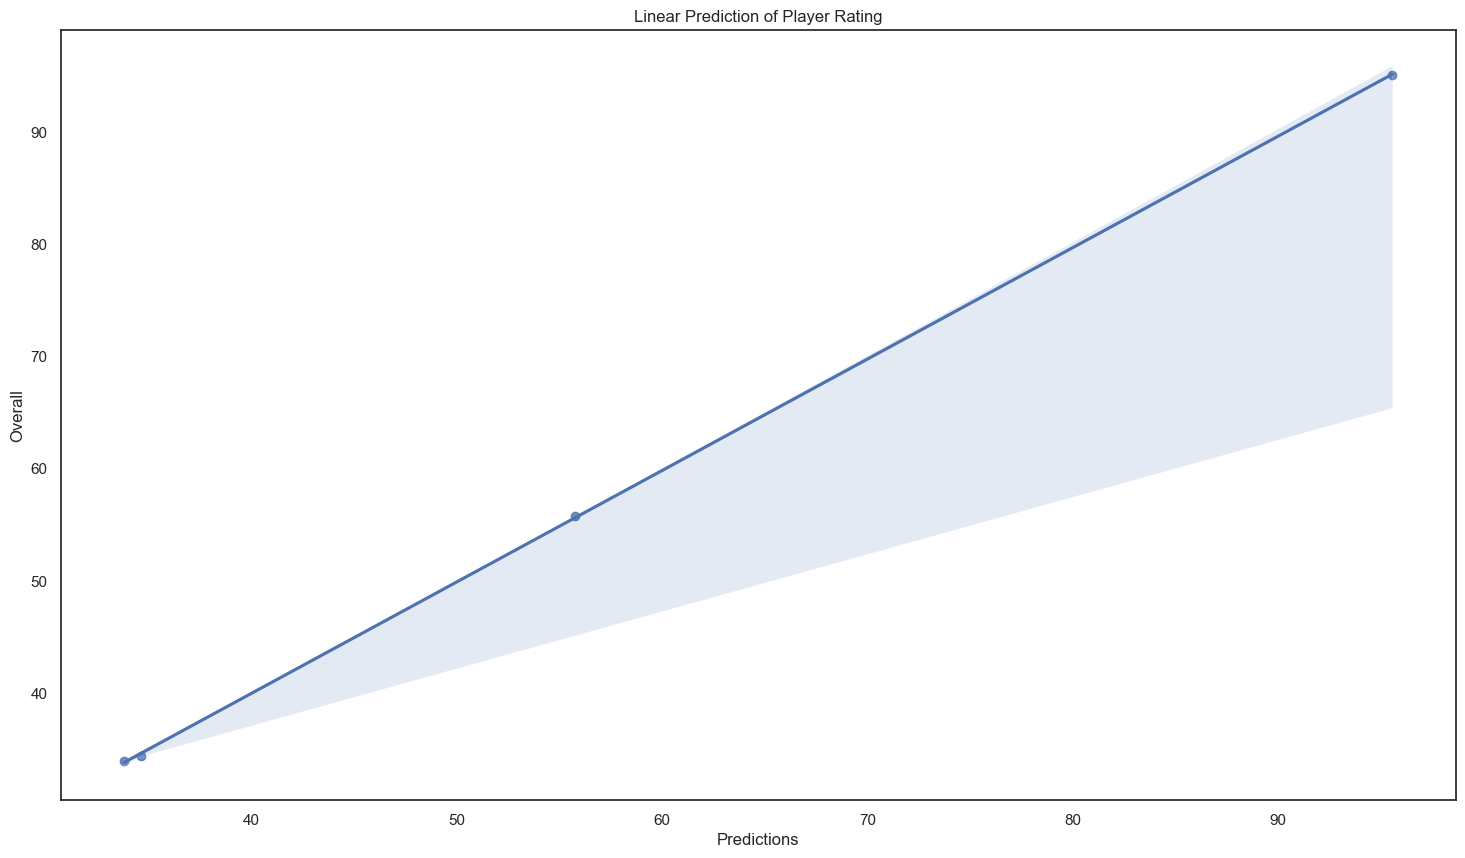

In [85]:
#Visualising the results
plt.figure(figsize=(18,10))
sns.regplot(predictions,y_test)
plt.xlabel('Predictions')
plt.ylabel('Overall')
plt.title("Linear Prediction of Player Rating")
plt.show()

## Conclusion

In conclusion, the purpose of this project was to find the appropiate technic to predict the outcome of possible matches in the premier league. This is no easy task as football is a very complex sport with very unpredictable variable, specially in this league, where any team can be another. Based on the analysis covered